# CATE Estimation Disparity Between Minority and Majority Groups

In [1]:
# imports
import time
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import econml
from econml.grf import CausalForest
from RATE import *
# set numpy seed
np.random.seed(0)

In [79]:
NUM_SIMULATIONS = 50  # global constant for number of simulations

In [3]:
global_start_time = time.time()

## Simulated Data Generation

Simulate a dataset where a protected variable is imbalanced. The other confonders include categorical and continuous covariates. The treatment is randomly assigned and the treatment effect is locally linear. We want the CATE function to share similarities between the majority and minority groups but are also slightly different. The reason is that if the CATE functions are identical across the board, then only training on the majority group makes it correct on the minority group also.

In [5]:
def var_imbalanced_data_locallinearTE(n=4000, propensity=0.5, p_protect=0.1, m_categorical=2, m_continuous=3):
    # imbalanced protected variable
    X_protect = np.random.choice([0,1], size=(n, 1), p=[1-p_protect, p_protect])
    # some categorical
    X_categorical = np.random.choice([0,1], size=(n, m_categorical), p=[0.5, 0.5])
    # some continuous
    X_continuous = np.random.normal(0, 1, size=(n, m_continuous))
    # m = 1+m_categorical+m_continuous
    X = np.concatenate((X_protect, X_categorical, X_continuous), axis=1)
    # random treatment assignment
    W = np.random.choice([0,1], n, p=[1-propensity, propensity])
    # if the treatment effect is linear, then the linear model is correctly specified
    Tau = X_protect[:,0] + X_categorical[:,0] + X_continuous[:,0] + (1-X_protect[:, 0]) * X_continuous[:,1]
    Y = np.maximum(np.sum(X, axis=1), 0.0) + W * Tau
    return np.var(Y)

In [6]:
var_temp = []
for i in range(100):
    var_temp.append(var_imbalanced_data_locallinearTE())
signal_var = np.mean(var_temp)
signal_var

4.948027866704653

Thus, default signal to noise ratio  (variance of Y over variance of noise) is rougly 4.95 by default. Cite TOM

In [7]:
def gen_imbalanced_data_locallinearTE(n=4000, propensity=0.5, p_protect=0.1, m_categorical=2, m_continuous=3, noise_var=1.0):
    # imbalanced protected variable
    X_protect = np.random.choice([0,1], size=(n, 1), p=[1-p_protect, p_protect])
    # some categorical
    X_categorical = np.random.choice([0,1], size=(n, m_categorical), p=[0.5, 0.5])
    # some continuous
    X_continuous = np.random.normal(0, 1, size=(n, m_continuous))
    # m = 1+m_categorical+m_continuous
    X = np.concatenate((X_protect, X_categorical, X_continuous), axis=1)
    # random treatment assignment
    W = np.random.choice([0,1], n, p=[1-propensity, propensity])
    # if the treatment effect is linear, then the linear model is correctly specified
    Tau = X_protect[:,0] + X_categorical[:,0] + X_continuous[:,0] + (1-X_protect[:, 0]) * X_continuous[:,1]
    Y = np.maximum(np.sum(X, axis=1), 0.0) + W * Tau + np.random.normal(0, np.sqrt(noise_var), n)
    return X, W, Tau, Y

In [8]:
X_train, W_train, Tau_train, Y_train = gen_imbalanced_data_locallinearTE()
X_test, W_test, Tau_test, Y_test = gen_imbalanced_data_locallinearTE(n=1000)
# sanity check:
# shapes, should expect 4000x6, 4000, 4000, and 4000
print(X_train.shape, W_train.shape, Tau_train.shape, Y_train.shape)
# should expect numbers close to 0.1, 0.5, and 0
print(np.sum(X_train[:,0]) / len(X_train), np.sum(W_train) / len(W_train), np.sum(X_train[:,-1]) / len(X_train))
print("Some examples of Y:", Y_train[:5])

(4000, 6) (4000,) (4000,) (4000,)
0.099 0.5075 -0.014971048979290618
Some examples of Y: [ 0.35662502 -1.82965253  0.32001901 10.01293545 -1.0836711 ]


In [9]:
print(np.mean(Tau_train)) # has an expectation of 0.6

0.5630638624059311


### Graphing

In [10]:
def eval_MSE_twoGroups(CATE_pred, X, Tau, verbose = False):
    # minority group performance
    if len(np.where(X[:,0] == 1)[0]) != 0:
        CATE_pred_minority = CATE_pred[X[:,0] == 1]
        Tau_minority = Tau[X[:,0] == 1]
        MSE_minority = mean_squared_error(Tau_minority, CATE_pred_minority)
    else:
        MSE_minority = 0.0
    # majority group performance
    if len(np.where(X[:,0] == 0)[0]) != 0:
        CATE_pred_majority = CATE_pred[X[:,0] == 0]
        Tau_majority = Tau[X[:,0] == 0]
        MSE_majority = mean_squared_error(Tau_majority, CATE_pred_majority)
    else:
        MSE_majority = 0.0
    
    MSE_diff = MSE_minority - MSE_majority
    
    if verbose:
        print(f"The MSE on minority group is {MSE_minority: .3f}. The MSE on majority group is {MSE_majority: .3f}. The difference is {MSE_diff: .3f}.")
    return MSE_minority, MSE_majority, MSE_diff 

In [11]:
def plot_MSEdiff_protect(p_protect,  MSE_diff, name=None, custom_yticks=None):
    plt.scatter(p_protect[1:-1], MSE_diff[1:-1], color='blue', s=5)
    plt.axvline(x=0.1, color="black", linestyle='--')
    plt.axvline(x=0.9, color="black", linestyle='--')
    plt.axhline(y=0.0, color="grey", linestyle='--')

    plt.xlabel('Probability of protected variable = 1')
    plt.ylabel('Minority group MSE - Majority group MSE')

    custom_xticks = [i/10 for i in range(11)]     # Custom x-axis tick locations
    if custom_yticks is None:
        custom_yticks = [i/2-2 for i in range(9)]  # Custom y-axis tick locations
    plt.xticks(custom_xticks)
    plt.yticks(custom_yticks)
    plt.title('MSE_diff vs. p_protect')

    plt.tight_layout()
    if name is not None:
        plt.savefig(name, dpi=200)
    plt.show()

In [12]:
def plot_MSEratio_protect(p_protect, MSE_minority, MSE_majority, name = None, custom_yticks=None):
    # also consider log of the ratio
    plt.scatter(p_protect[1:-1], np.array(MSE_minority[1:-1]) / np.array(MSE_majority[1:-1]), color='blue', s=5)
    plt.yscale('log')
    plt.axvline(x=0.1, color="black", linestyle='--')
    plt.axvline(x=0.9, color="black", linestyle='--')
    plt.axhline(y=1.0, color="grey", linestyle='--')
    
    plt.xlabel('Probability of protected variable = 1')
    plt.ylabel('Minority group MSE / Majority group MSE')

    custom_xticks = [i/10 for i in range(11)]     # Custom x-axis tick locations
    if custom_yticks is None:
        custom_yticks = [1e-2, 1e-1, 1e0, 1e1, 1e2]  # Custom y-axis tick locations
    plt.xticks(custom_xticks)
    plt.yticks(custom_yticks)
    plt.title('MSE_ratio vs. p_protect')
    
    plt.tight_layout()
    if name is not None:
        plt.savefig(name, dpi=200)
    plt.show()

In [13]:
# generate a 2 by 2 plot.
# 2 plots are how ratio in the two MSEs changes with weight on minority group for training and testing sets
# the other 2 are "ROC curves with MSE on minority group against MSE on majority group"

def plot_MSE(mu_list, train_min, train_maj, train_diff, test_min, test_maj, test_diff, 
             name=None, custom_xticks=None, custom_yticks=None, min_MSE=0, max_MSE=1.5, optimal_points = None):
    
    plt.figure(figsize=(10,8))
    
    # plot ratio of MSE with respect to weight on minority (Train)
    plt.subplot(2, 2, 1)
    scatter_1 = plt.scatter(mu_list, np.array(train_min) / np.array(train_maj), c=mu_list, cmap='viridis', s=np.array(mu_list)/2+3)
    plt.yscale('log')
    plt.colorbar(scatter_1, label='weight on minority group')
    plt.axvline(x=1, color="grey", linestyle='--')
    plt.axhline(y=1.0, color="grey", linestyle='--')
    plt.xlabel('Weight on minority group')
    plt.ylabel('Minority group MSE / Majority group MSE')
    if custom_xticks is None:
        custom_xticks = [i*2 for i in range(11)] # Custom x-axis tick locations
    if custom_yticks is None:
        custom_yticks = [1e-1, 1e0, 1e1, 1e2] # Custom y-axis tick locations
    plt.xticks(custom_xticks)
    plt.yticks(custom_yticks)
    plt.title('MSE_ratio vs. weight on minority group (Train)')
    
    #  plot ratio of MSE with respect to weight on minority (Test)
    plt.subplot(2, 2, 2)
    scatter_2 = plt.scatter(mu_list, np.array(test_min) / np.array(test_maj), c=mu_list, cmap='viridis', s=np.array(mu_list)/2+3)
    plt.yscale('log')
    plt.colorbar(scatter_2, label='weight on minority group')
    plt.axvline(x=1, color="grey", linestyle='--')
    plt.axhline(y=1.0, color="grey", linestyle='--')
    plt.xlabel('Weight on minority group')
    plt.ylabel('Minority group MSE / Majority group MSE')
    if custom_xticks is None:
        custom_xticks = [i*2 for i in range(11)] # Custom x-axis tick locations
    if custom_yticks is None:
        custom_yticks = [1e-1, 1e0, 1e1, 1e2] # Custom y-axis tick locations
    plt.xticks(custom_xticks)
    plt.yticks(custom_yticks)
    plt.title('MSE_ratio vs. weight on minority group (Test)')
    
    # plot MSE on majority vs. on minority (Train)
    plt.subplot(2, 2, 3)
    # smaller circles indicate smaller weight
    scatter_3 = plt.scatter(train_min, train_maj, c=mu_list, cmap='viridis', s=np.array(mu_list)/2+3)
    if optimal_points is not None:
        plt.scatter(optimal_points[0], optimal_points[1], color='red', marker='o', s=15, label = "Optimal MSEs")
    plt.colorbar(scatter_3, label='weight on minority group')
    plt.plot(np.linspace(min_MSE, max_MSE, 100), np.linspace(min_MSE, max_MSE, 100), linestyle='--', color='grey')
    plt.xlabel('MSE on minority group')
    plt.ylabel('MSE on majority group')
    plt.axis('equal')
    plt.title('MSE on majority group vs. minority group (Train)')
    if optimal_points is not None:
        plt.legend(loc='upper left')
    
    # plot MSE on majority vs. on minority (Test)
    plt.subplot(2, 2, 4)
    # smaller circles indicate smaller weight
    scatter_4 = plt.scatter(test_min, test_maj, c=mu_list, cmap='viridis', s=np.array(mu_list)/2+3)
    if optimal_points is not None:
        plt.scatter(optimal_points[2], optimal_points[3], color='red', marker='o', s=15, label = "Optimal MSEs")
    plt.colorbar(scatter_4, label='weight on minority group')
    plt.plot(np.linspace(min_MSE, max_MSE, 100), np.linspace(min_MSE, max_MSE, 100), linestyle='--', color='grey')
    plt.xlabel('MSE on minority group')
    plt.ylabel('MSE on majority group')
    plt.axis('equal')
    plt.title('MSE on majority group vs. minority group (Test)')
    if optimal_points is not None:
        plt.legend(loc='upper left')
    
    plt.tight_layout()
    if name is not None:
        plt.savefig(name, dpi=200)
    plt.show()

## Doubly Robust Pseudo-outcome

In [80]:
# TODO: check if reweighting is done this way!
# Change to AIPW since randomized control
def DR_linear_estimator(X, W, Y, weight_minority=1.0):
    sample_weights = X[:,0] * (weight_minority-1.0) + 1.0
    # propensity = LinearRegression(n_jobs=-1)
    # control_nuissance = LinearRegression(n_jobs=-1)
    # treatment_nuissance = LinearRegression(n_jobs=-1)
    
    # use non-parametric for nuissance
    # control_nuissance = econml.grf.RegressionForest(n_estimators=200)
    # treatment_nuissance = econml.grf.RegressionForest(n_estimators=200)

    # propensity.fit(X, W, sample_weight = sample_weights)
    # control_nuissance.fit(X[W==0], Y[W==0], sample_weight = sample_weights[W==0])
    # treatment_nuissance.fit(X[W==1], Y[W==1], sample_weight = sample_weights[W==1])
    # control_nuissance.fit(X[W==0], Y[W==0])
    # treatment_nuissance.fit(X[W==1], Y[W==1])

    # pseudo_outcome_Y = treatment_nuissance.predict(X) - control_nuissance.predict(X) + W*(Y-treatment_nuissance.predict(X))/propensity.predict(X) - (1-W)*(Y-control_nuissance.predict(X))/(1-propensity.predict(X))
    # pseudo_outcome_Y = treatment_nuissance.predict(X) - control_nuissance.predict(X) + W*(Y-treatment_nuissance.predict(X))/0.5 - (1-W)*(Y-control_nuissance.predict(X))/0.5
    # pseudo_outcome_Y = treatment_nuissance.predict(X).flatten() - control_nuissance.predict(X).flatten() + W*(Y-treatment_nuissance.predict(X).flatten())/0.5 - (1-W)*(Y-control_nuissance.predict(X).flatten())/0.5
    pseudo_outcome_Y = get_scores(X, Y, W, e=np.mean(W), m=None, params={'n_estimators': 200}, scoring_type="AIPW")
    
    model = LinearRegression(n_jobs=-1)
    model.fit(X, pseudo_outcome_Y, sample_weight = sample_weights)
    return model, pseudo_outcome_Y

In [81]:
def get_huber_white_var(X, Y_hat, p, gamma):
    A = np.diag(X[:,0] * (gamma-1.0) + 1.0)
    n = X.shape[0]
    ones_column = np.ones((n, 1), dtype=X.dtype)
    X = np.hstack((X, ones_column))
    G = (X.T @ A @ X)
    G_inv = np.linalg.inv(G)
    beta = np.array([[1.0, 1.0, 0.0, 1.0, (1.0-p)/(p*gamma+1.0-p), 0.0, 0.0]])
    eps = Y_hat - (X @ beta.T).flatten()
    eps = np.diag(eps)
    return G_inv @ (X.T @ A @ eps @ eps.T @ A.T @ X) @ G_inv

In [82]:
model, pseudo_outcome_Y = DR_linear_estimator(X_train, W_train, Y_train, weight_minority=1.0)
start_time = time.time()
var = get_huber_white_var(X_train, pseudo_outcome_Y, 0.1, 1.0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.21602392196655273 seconds ---


In [83]:
def get_variance(var):
    min_var = (var[-1,-1] + 2*var[0,-1] + var[1,-1] + var[2,-1]) + (var[0,0] + var[0,1] + var[0,2]) + (var[1,1]/2 + var[1,2]/4)
    min_var += var[2,2]/2 + var[3,3] + var[4,4] + var[5,5]
    maj_var = (var[-1,-1] + var[1,-1] + var[2,-1]) + (var[1,1]/2 + var[1,2]/4)
    maj_var += var[2,2]/2 + var[3,3] + var[4,4] + var[5,5]
    return min_var, maj_var

In [84]:
get_variance(var)

(0.039416563538126836, 0.011799246246097387)

In [85]:
def run_DR_linear_simulation(num_simulations=NUM_SIMULATIONS, weight=1.0, p_protect=0.1, noise_var=1.0):
    MSE_minority_train, MSE_majority_train, MSE_diff_train = [], [], []
    MSE_minority_test, MSE_majority_test, MSE_diff_test = [], [], []
    min_vars, maj_vars = [], []
    for i in range(num_simulations):
        X_train, W_train, Tau_train, Y_train = gen_imbalanced_data_locallinearTE(p_protect=p_protect, noise_var=noise_var)
        X_test, W_test, Tau_test, Y_test = gen_imbalanced_data_locallinearTE(n=1000, p_protect=p_protect, noise_var=noise_var)
        model, pseudo_outcome_Y = DR_linear_estimator(X_train, W_train, Y_train, weight_minority=weight)
        var = get_huber_white_var(X_train, pseudo_outcome_Y, p_protect, weight)
        min_var, maj_var = get_variance(var)
        min_vars.append(min_var)
        maj_vars.append(maj_var)
        # eval on train data
        MSE_minority, MSE_majority, MSE_diff = eval_MSE_twoGroups(model.predict(X_train), X_train, Tau_train)
        MSE_minority_train.append(MSE_minority)
        MSE_majority_train.append(MSE_majority)
        MSE_diff_train.append(MSE_diff)
        # eval on test data
        MSE_minority, MSE_majority, MSE_diff = eval_MSE_twoGroups(model.predict(X_test), X_test, Tau_test)
        MSE_minority_test.append(MSE_minority)
        MSE_majority_test.append(MSE_majority)
        MSE_diff_test.append(MSE_diff)
    return MSE_minority_train, MSE_majority_train, MSE_diff_train, MSE_minority_test, MSE_majority_test, MSE_diff_test, np.mean(min_vars), np.mean(maj_vars)

In [86]:
start_time = time.time()
MSE_minority_train, MSE_majority_train, MSE_diff_train, MSE_minority_test, MSE_majority_test, MSE_diff_test, min_var, maj_var = run_DR_linear_simulation()
print("--- %s seconds ---" % (time.time() - start_time))
# stddev of sample mean is stddev of sample divided by sqrt(sample size)
# mean diff, stddev of mean diff, minimum diff, maximum diff
print(np.mean(MSE_diff_train), np.std(MSE_diff_train)/ np.sqrt(len(MSE_diff_train)), np.min(MSE_diff_train), np.max(MSE_diff_train))
print(np.mean(MSE_diff_test), np.std(MSE_diff_test)/ np.sqrt(len(MSE_diff_test)), np.min(MSE_diff_test), np.max(MSE_diff_test))
print(min_var, maj_var)

--- 51.53630805015564 seconds ---
0.8085423733402003 0.016101456448451044 0.560897928251674 1.087373459385818
0.8325569370622068 0.021864530522633638 0.6160298740670558 1.297851560666735
0.041694142437817716 0.011984589035571796


In [87]:
# plot difference in MSE with respect to p_protect
p_protect = []
MSE_diff = []
MSE_minority = []
MSE_majority = []
min_vars_p = []
maj_vars_p = []
start_time = time.time()
for i in range(1, 100):
    p = i / 100
    p_protect.append(p)
    _, _, _, MSE_minority_test, MSE_majority_test, MSE_diff_test, min_var, maj_var = run_DR_linear_simulation(p_protect=p)
    MSE_minority.append(np.mean(MSE_minority_test))
    MSE_majority.append(np.mean(MSE_majority_test))
    MSE_diff.append(np.mean(MSE_diff_test))
    min_vars_p.append(min_var)
    maj_vars_p.append(maj_var)
print("--- %s seconds ---" % (time.time() - start_time))

--- 6145.765292882919 seconds ---


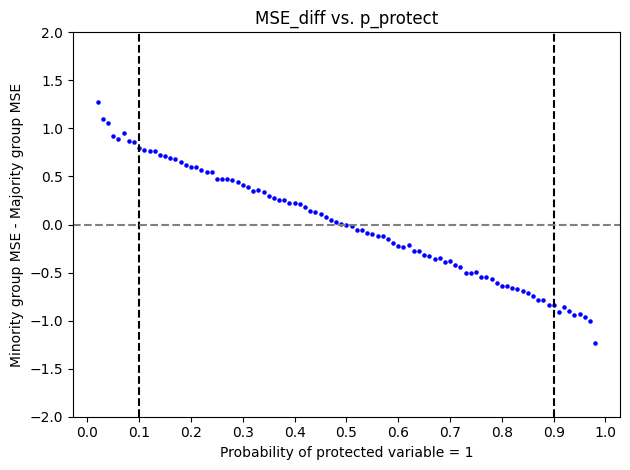

In [20]:
plot_MSEdiff_protect(p_protect, MSE_diff, "locallinearTau_DRLearner_linearEstimator_MSEdiffOnProb")

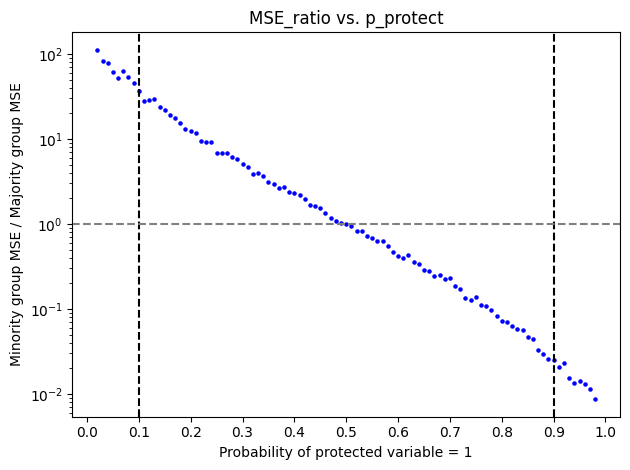

In [21]:
plot_MSEratio_protect(p_protect, MSE_minority, MSE_majority, "locallinearTau_DRLearner_linearEstimator_MSEratioOnProb")

In [88]:
mu_list = []
MSE_minority_train_list, MSE_majority_train_list, MSE_diff_train_list = [], [], []
MSE_minority_test_list, MSE_majority_test_list, MSE_diff_test_list = [], [], []
min_vars_g = []
maj_vars_g = []
for i in range(1, 81):
    # mu in (0,20]
    mu_list.append(i/4)
    MSE_minority_train, MSE_majority_train, MSE_diff_train, MSE_minority_test, MSE_majority_test, MSE_diff_test, min_var, maj_var = run_DR_linear_simulation(weight=i/4)
    MSE_minority_train_list.append(np.mean(MSE_minority_train))
    MSE_majority_train_list.append(np.mean(MSE_majority_train))
    MSE_diff_train_list.append(np.mean(MSE_diff_train))
    MSE_minority_test_list.append(np.mean(MSE_minority_test))
    MSE_majority_test_list.append(np.mean(MSE_majority_test))
    MSE_diff_test_list.append(np.mean(MSE_diff_test))
    min_vars_g.append(min_var)
    maj_vars_g.append(maj_var)

In [23]:
# optimal points if trained on minority or majority group alone. 
def run_DR_linear_simulation_minority(num_simulations=NUM_SIMULATIONS, weight=1.0, p_protect=0.1, noise_var=1.0):
    MSE_minority_train, MSE_minority_test = [], []
    for i in range(num_simulations):
        X_train, W_train, Tau_train, Y_train = gen_imbalanced_data_locallinearTE(p_protect=p_protect, noise_var=noise_var)
        X_test, W_test, Tau_test, Y_test = gen_imbalanced_data_locallinearTE(n=1000, p_protect=p_protect, noise_var=noise_var)
        min_index = np.where(X_train[:,0] == 1)[0]
        model = DR_linear_estimator(X_train[min_index], W_train[min_index], Y_train[min_index], weight_minority=weight)
        # eval on train data
        MSE_minority, MSE_majority, MSE_diff = eval_MSE_twoGroups(model.predict(X_train[min_index]), X_train[min_index], Tau_train[min_index])
        MSE_minority_train.append(MSE_minority)
        # eval on test data
        min_index = np.where(X_test[:,0] == 1)[0]
        MSE_minority, MSE_majority, MSE_diff = eval_MSE_twoGroups(model.predict(X_test[min_index]), X_test[min_index], Tau_test[min_index])
        MSE_minority_test.append(MSE_minority)
    return np.mean(MSE_minority_train), np.mean(MSE_minority_test)

In [24]:
optimal_MSE_min_train, optimal_MSE_min_test = run_DR_linear_simulation_minority()

In [25]:
# optimal points if trained on minority or majority group alone. 
def run_DR_linear_simulation_majority(num_simulations=NUM_SIMULATIONS, weight=1.0, p_protect=0.1, noise_var=1.0):
    MSE_majority_train, MSE_majority_test = [], []
    for i in range(num_simulations):
        X_train, W_train, Tau_train, Y_train = gen_imbalanced_data_locallinearTE(p_protect=p_protect, noise_var=noise_var)
        X_test, W_test, Tau_test, Y_test = gen_imbalanced_data_locallinearTE(n=1000, p_protect=p_protect, noise_var=noise_var)
        maj_index = np.where(X_train[:,0] == 0)[0]
        model = DR_linear_estimator(X_train[maj_index], W_train[maj_index], Y_train[maj_index], weight_minority=weight)
        # eval on train data
        MSE_minority, MSE_majority, MSE_diff = eval_MSE_twoGroups(model.predict(X_train[maj_index]), X_train[maj_index], Tau_train[maj_index])
        MSE_majority_train.append(MSE_majority)
        # eval on test data
        maj_index = np.where(X_test[:,0] == 0)[0]
        MSE_minority, MSE_majority, MSE_diff = eval_MSE_twoGroups(model.predict(X_test[maj_index]), X_test[maj_index], Tau_test[maj_index])
        MSE_majority_test.append(MSE_majority)
    return np.mean(MSE_majority_train), np.mean(MSE_majority_test)

In [26]:
optimal_MSE_maj_train, optimal_MSE_maj_test = run_DR_linear_simulation_majority()

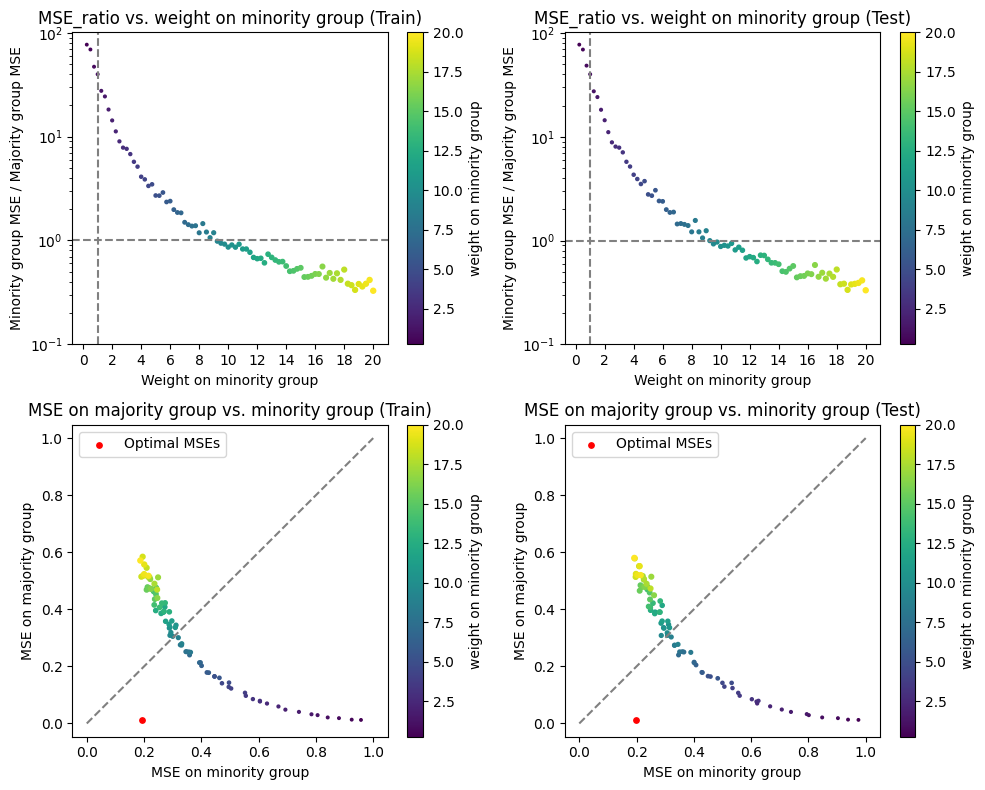

In [27]:
plot_MSE(mu_list, MSE_minority_train_list, MSE_majority_train_list, MSE_diff_train_list, 
         MSE_minority_test_list, MSE_majority_test_list, MSE_diff_test_list, 
         'locallinearTau_DRLearner_linearEstimator_MSEViz_5.0SNR.png', max_MSE=1.0, 
         optimal_points = [optimal_MSE_min_train, optimal_MSE_maj_train, optimal_MSE_min_test, optimal_MSE_maj_test])

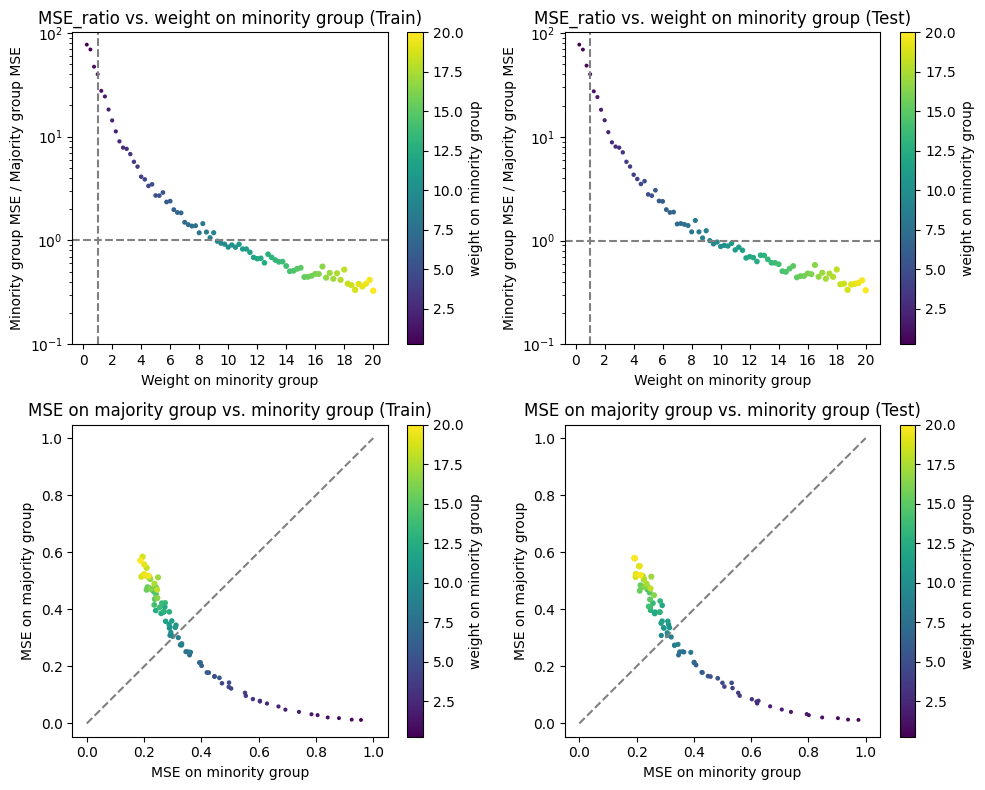

In [28]:
plot_MSE(mu_list, MSE_minority_train_list, MSE_majority_train_list, MSE_diff_train_list, 
         MSE_minority_test_list, MSE_majority_test_list, MSE_diff_test_list, 
         'locallinearTau_DRLearner_linearEstimator_MSEViz.png', max_MSE=1.0)

## Theoretical Results

In [29]:
score_vars = []
score_vars_min = []
score_vars_maj = []
for j in range(1, 100):
    p = j / 100
    score_variance = []
    score_variance_min = []
    score_variance_maj = []
    for i in range(NUM_SIMULATIONS):
        X_train, W_train, Tau_train, Y_train = gen_imbalanced_data_locallinearTE(p_protect=p)
        pseudo_outcome_Y = get_scores(X_train, Y_train, W_train, e=np.mean(W_train), m=None, params={'n_estimators': 200}, scoring_type="AIPW")
        score_variance.append(np.var(pseudo_outcome_Y - Tau_train))
        min_index = np.where(X_train[:,0] == 1)[0]
        score_variance_min.append(np.var(pseudo_outcome_Y[min_index] - Tau_train[min_index]))
        maj_index = np.where(X_train[:,0] == 0)[0]
        score_variance_maj.append(np.var(pseudo_outcome_Y[maj_index] - Tau_train[maj_index]))
    score_vars.append(np.mean(score_variance))
    score_vars_min.append(np.mean(score_variance_min))
    score_vars_maj.append(np.mean(score_variance_maj))

In [30]:
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.tools.tools import add_constant
X_train, W_train, Tau_train, Y_train = gen_imbalanced_data_locallinearTE(p_protect=0.1)
pseudo_outcome_Y = get_scores(X_train, Y_train, W_train, e=np.mean(W_train), m=None, params={'n_estimators': 200}, scoring_type="AIPW")
min_index = np.where(X_train[:,0] == 1)[0]
maj_index = np.where(X_train[:,0] == 0)[0]

In [31]:
bp_test = het_breuschpagan(pseudo_outcome_Y - Tau_train,  add_constant(X_train))
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, bp_test)))

{'LM Statistic': 235.79051047811416, 'LM-Test p-value': 4.4470394267375803e-48, 'F-Statistic': 41.68699567863747, 'F-Test p-value': 1.4722264987151831e-49}


In [32]:
bp_test = het_breuschpagan(pseudo_outcome_Y[min_index] - Tau_train[min_index],  add_constant(X_train[min_index]))
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, bp_test)))

{'LM Statistic': 99.67742145189239, 'LM-Test p-value': 6.180749567304494e-20, 'F-Statistic': 26.092311693918344, 'F-Test p-value': 8.550031266875696e-23}


In [33]:
bp_test = het_breuschpagan(pseudo_outcome_Y[maj_index] - Tau_train[maj_index],  add_constant(X_train[maj_index]))
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, bp_test)))

{'LM Statistic': 110.59734701793523, 'LM-Test p-value': 1.5282505720080268e-21, 'F-Statistic': 22.7830869048761, 'F-Test p-value': 1.4093037376094499e-22}


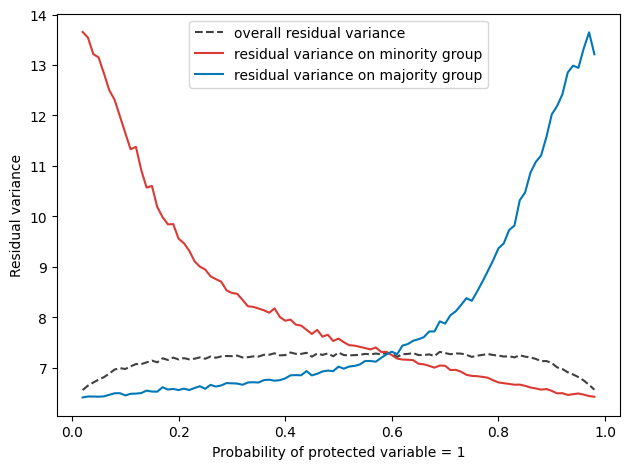

In [34]:
plt.plot([x/100 for x in range(2,99)], score_vars[1:-1], label='overall residual variance', linestyle='--', color='#404040')
plt.plot([x/100 for x in range(2,99)], score_vars_min[1:-1], label='residual variance on minority group', color='#db3a34')
plt.plot([x/100 for x in range(2,99)], score_vars_maj[1:-1], label='residual variance on majority group', color='#0077b6')
plt.xlabel('Probability of protected variable = 1')
plt.ylabel('Residual variance')
plt.legend()
plt.tight_layout()
plt.savefig("Residual variance of score.png", dpi=200)
plt.show()

Score's variance on the minority group is 11.627 and the score's variance on the majority group is 6.46. Overall variance is 7.0 ish.

In [35]:
# only works if homoscedastic variance
def calc_var_theory(r, p, min=True):
    first_part = (5*(np.square(r)-1)*p+5) / (np.square(r*p+1-p)) + (1 / (1-p))
    if min:
        if isinstance(p, float):
            return first_part + (1-2*p*r) / (p*r*(1-p))
        else:
            return first_part + (1-2*p*r) / (p*r*(1-p))
    else:
        return first_part

In [36]:
def var_ratio(r, p):
    return calc_var_theory(r, p, min = True) / calc_var_theory(r, p, min = False)

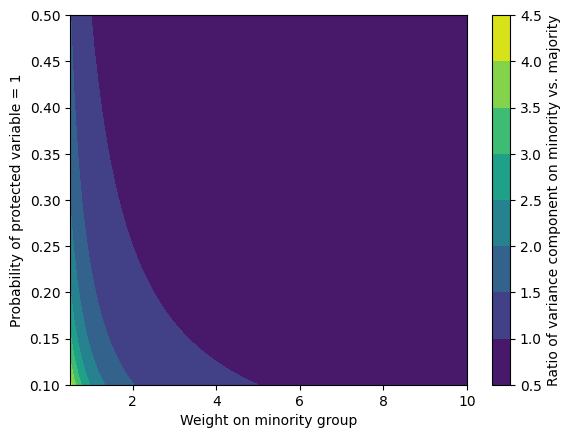

In [37]:
from matplotlib import colors
# Define the ranges for x and y
x_range = np.linspace(0.5, 10, 100)
y_range = np.linspace(0.1,0.5,100)

# Create a grid of x and y values
X, Y = np.meshgrid(x_range, y_range)

# Evaluate the equation for each combination of x and y
Z = var_ratio(X, Y)

# Create the contour plot
plt.contourf(X, Y, Z, cmap='viridis')
plt.colorbar(label='Ratio of variance component on minority vs. majority')
plt.xlabel('Weight on minority group')
plt.ylabel('Probability of protected variable = 1')
plt.savefig("variance_ratio_component.png", dpi=200)
plt.show()

In [63]:
def calc_mse_theory(r, p, min=True):
    if min:
        return np.square((1-p) / (p*r+1-p))
    else:
        return np.square((p*r) / (p*r+1-p))

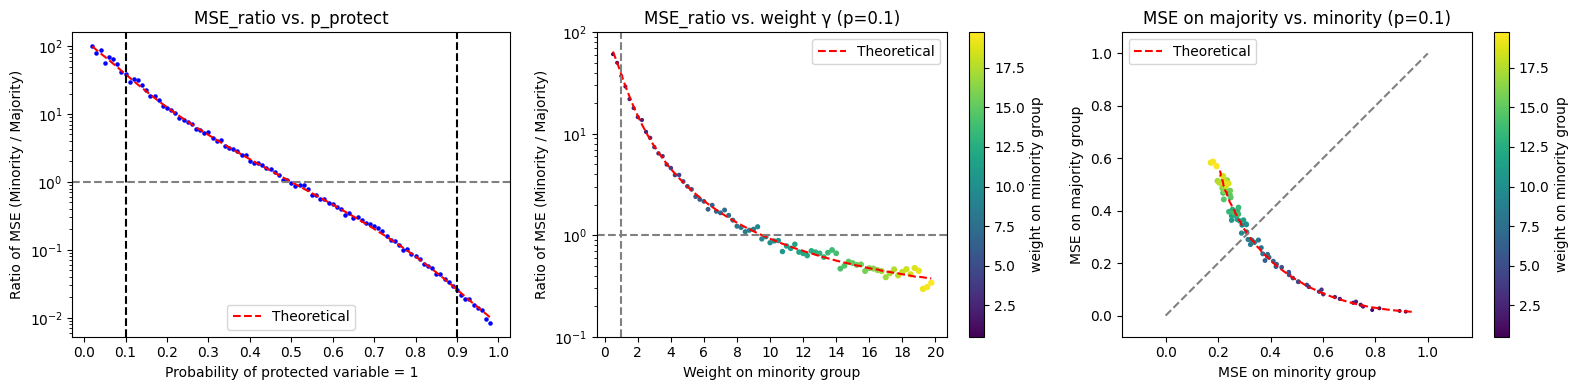

In [89]:
# try to plot it with theoretical results overlayed on top.
plt.figure(figsize=(16,4))

plt.subplot(1, 3, 1)
plt.scatter(p_protect[1:-1], np.array(MSE_minority[1:-1]) / np.array(MSE_majority[1:-1]), color='blue', s=5)
x = np.array(p_protect[1:-1])
plt.plot(x, (calc_mse_theory(1.0,x) + np.array(min_vars_p[1:-1])) / (calc_mse_theory(1.0,x,min=False) + np.array(maj_vars_p[1:-1])), label='Theoretical', linestyle='dashed', color='red')
plt.yscale('log')
plt.axvline(x=0.1, color="black", linestyle='--')
plt.axvline(x=0.9, color="black", linestyle='--')
plt.axhline(y=1.0, color="grey", linestyle='--')

plt.xlabel('Probability of protected variable = 1')
plt.ylabel('Ratio of MSE (Minority / Majority)')

custom_xticks = [i/10 for i in range(11)]     # Custom x-axis tick locations
custom_yticks = [1e-2, 1e-1, 1e0, 1e1, 1e2]  # Custom y-axis tick locations
plt.xticks(custom_xticks)
plt.yticks(custom_yticks)
plt.title('MSE_ratio vs. p_protect')
plt.legend()


plt.subplot(1, 3, 2)
scatter_2 = plt.scatter(mu_list[1:-1], np.array(MSE_minority_test_list[1:-1]) / np.array(MSE_majority_test_list[1:-1]), c=mu_list[1:-1], cmap='viridis', s=np.array(mu_list[1:-1])/2+3)
x = np.array(mu_list[1:-1])
p=0.1
y = (calc_mse_theory(x,p) + np.array(min_vars_g[1:-1])) / (calc_mse_theory(x,p,min=False) + np.array(maj_vars_g[1:-1]))
plt.plot(x, y, label='Theoretical', linestyle='dashed', color='red')
plt.yscale('log')
plt.colorbar(scatter_2, label='weight on minority group')
plt.axvline(x=1, color="grey", linestyle='--')
plt.axhline(y=1.0, color="grey", linestyle='--')
plt.xlabel('Weight on minority group')
plt.ylabel('Ratio of MSE (Minority / Majority)')
custom_xticks = [i*2 for i in range(11)] # Custom x-axis tick locations
custom_yticks = [1e-1, 1e0, 1e1, 1e2] # Custom y-axis tick locations
plt.xticks(custom_xticks)
plt.yticks(custom_yticks)
plt.title('MSE_ratio vs. weight γ (p=0.1)')
plt.legend()


plt.subplot(1, 3, 3)
scatter_3 = plt.scatter(MSE_minority_test_list[1:-1], MSE_majority_test_list[1:-1], c=mu_list[1:-1], cmap='viridis', s=np.array(mu_list[1:-1])/2+3)
p=0.1
plt.plot(calc_mse_theory(x,p) + np.array(min_vars_g[1:-1]), calc_mse_theory(x,p,min=False) + np.array(maj_vars_g[1:-1]), label='Theoretical', linestyle='dashed', color='red')
# plot optimal points if fit separate models
# optimal_points = [optimal_MSE_min_train, optimal_MSE_maj_train, optimal_MSE_min_test, optimal_MSE_maj_test]
# plt.scatter(optimal_points[0], optimal_points[1], color='green', marker='o', s=15, label = "Optimal MSEs")
plt.colorbar(scatter_3, label='weight on minority group')
plt.plot(np.linspace(0.0, 1.0, 100), np.linspace(0.0, 1.0, 100), linestyle='--', color='grey')
plt.xlabel('MSE on minority group')
plt.ylabel('MSE on majority group')
plt.axis('equal')
plt.title('MSE on majority vs. minority (p=0.1)')
plt.legend()

plt.subplots_adjust(hspace=5) 
plt.tight_layout()
plt.savefig("theoretical_overlay_simulation_3.png", dpi=200)
plt.show()


### Different Signal-to-noise ratio!

In [40]:
signal_var # default SNR

4.948027866704653

In [41]:
mu_list = []
MSE_minority_train_list, MSE_majority_train_list, MSE_diff_train_list = [], [], []
MSE_minority_test_list, MSE_majority_test_list, MSE_diff_test_list = [], [], []
for i in range(1, 81):
    # mu in (0,20]
    mu_list.append(i/4)
    MSE_minority_train, MSE_majority_train, MSE_diff_train, MSE_minority_test, MSE_majority_test, MSE_diff_test = run_DR_linear_simulation(weight=i/4, noise_var=5.0)
    MSE_minority_train_list.append(np.mean(MSE_minority_train))
    MSE_majority_train_list.append(np.mean(MSE_majority_train))
    MSE_diff_train_list.append(np.mean(MSE_diff_train))
    MSE_minority_test_list.append(np.mean(MSE_minority_test))
    MSE_majority_test_list.append(np.mean(MSE_majority_test))
    MSE_diff_test_list.append(np.mean(MSE_diff_test))

In [42]:
optimal_MSE_min_train, optimal_MSE_min_test = run_DR_linear_simulation_minority(noise_var=5.0)

In [43]:
optimal_MSE_maj_train, optimal_MSE_maj_test = run_DR_linear_simulation_majority(noise_var=5.0)

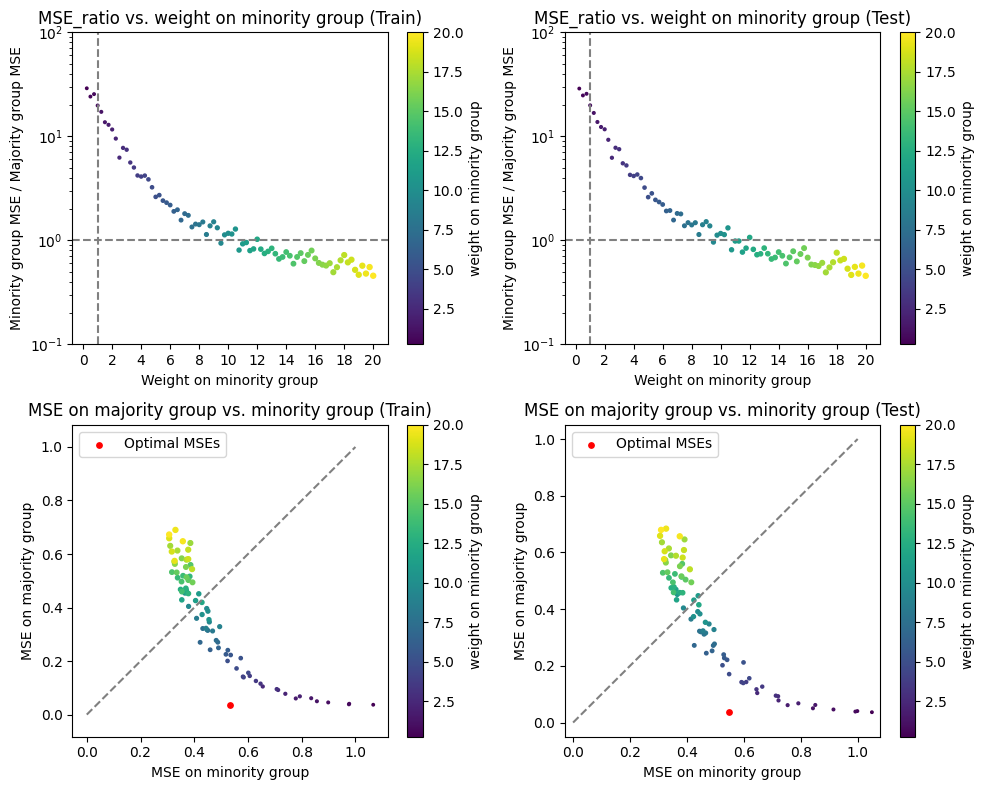

In [44]:
plot_MSE(mu_list, MSE_minority_train_list, MSE_majority_train_list, MSE_diff_train_list, 
         MSE_minority_test_list, MSE_majority_test_list, MSE_diff_test_list, 
         'locallinearTau_DRLearner_linearEstimator_MSEViz_1SNR.png', max_MSE=1.0, 
         optimal_points = [optimal_MSE_min_train, optimal_MSE_maj_train, optimal_MSE_min_test, optimal_MSE_maj_test])

In [45]:
mu_list = []
MSE_minority_train_list, MSE_majority_train_list, MSE_diff_train_list = [], [], []
MSE_minority_test_list, MSE_majority_test_list, MSE_diff_test_list = [], [], []
for i in range(1, 81):
    # mu in (0,20]
    mu_list.append(i/4)
    MSE_minority_train, MSE_majority_train, MSE_diff_train, MSE_minority_test, MSE_majority_test, MSE_diff_test = run_DR_linear_simulation(weight=i/4, noise_var=25.0)
    MSE_minority_train_list.append(np.mean(MSE_minority_train))
    MSE_majority_train_list.append(np.mean(MSE_majority_train))
    MSE_diff_train_list.append(np.mean(MSE_diff_train))
    MSE_minority_test_list.append(np.mean(MSE_minority_test))
    MSE_majority_test_list.append(np.mean(MSE_majority_test))
    MSE_diff_test_list.append(np.mean(MSE_diff_test))

In [46]:
optimal_MSE_min_train, optimal_MSE_min_test = run_DR_linear_simulation_minority(noise_var=25.0)

In [47]:
optimal_MSE_maj_train, optimal_MSE_maj_test = run_DR_linear_simulation_majority(noise_var=25.0)

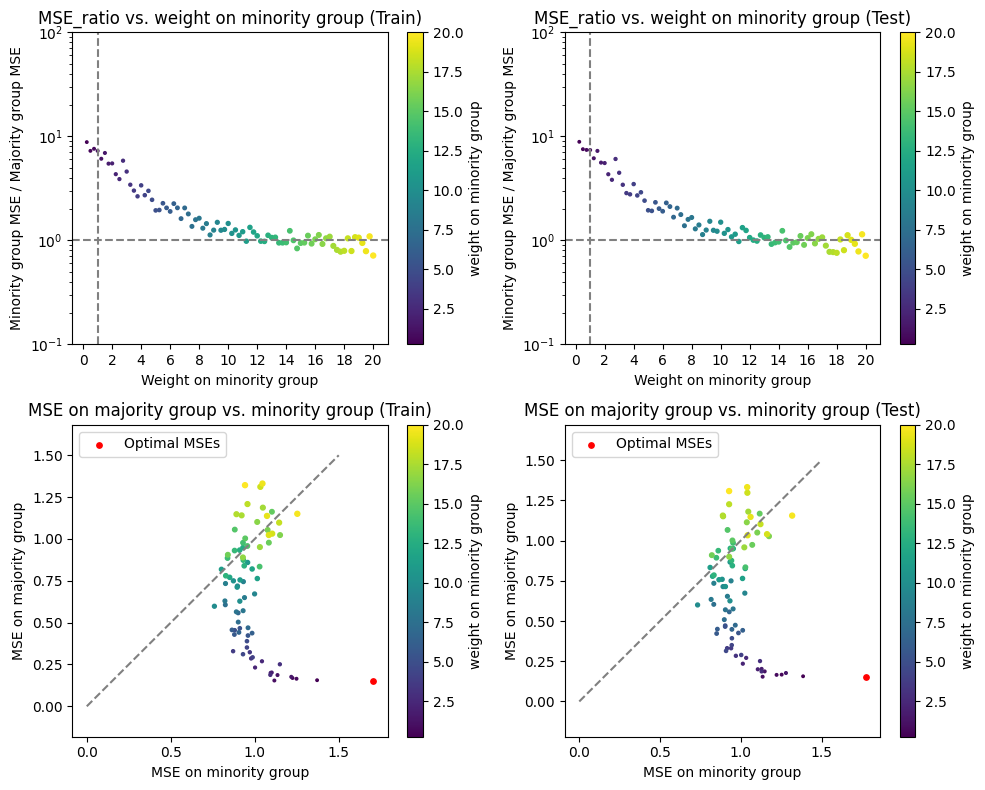

In [48]:
plot_MSE(mu_list, MSE_minority_train_list, MSE_majority_train_list, MSE_diff_train_list, 
         MSE_minority_test_list, MSE_majority_test_list, MSE_diff_test_list, 
         'locallinearTau_DRLearner_linearEstimator_MSEViz_0.2SNR.png', max_MSE=1.5, 
         optimal_points = [optimal_MSE_min_train, optimal_MSE_maj_train, optimal_MSE_min_test, optimal_MSE_maj_test])

## Causal Forest

In [11]:
def causalForest_estimator(X, W, Y, weight_minority=1.0, n_estimators=200):
    sample_weights = X[:,0] * (weight_minority-1.0) + 1.0
    model = CausalForest(n_estimators=n_estimators)
    model.fit(X, W, Y, sample_weight=sample_weights)
    return model

In [50]:
model = causalForest_estimator(X_train, W_train, Y_train)
CATE_pred = model.predict(X_train)[:,0]
print(np.abs(CATE_pred - Tau_train))
# seems reasonable

[0.19087267 0.10196047 0.19294064 ... 0.58712262 0.12638672 0.24500222]


In [51]:
eval_MSE_twoGroups(CATE_pred, X_train, Tau_train, verbose = True)

The MSE on minority group is  0.709. The MSE on majority group is  0.181. The difference is  0.528.


(0.7086844857105702, 0.18076548731121356, 0.5279189983993566)

In [52]:
CATE_pred_test = model.predict(X_test)[:,0]
eval_MSE_twoGroups(CATE_pred_test, X_test, Tau_test, verbose = True)

The MSE on minority group is  0.690. The MSE on majority group is  0.222. The difference is  0.468.


(0.6898977679764714, 0.22168874137815758, 0.4682090265983138)

In [89]:
def run_causalForest_simulation(num_simulations=NUM_SIMULATIONS, weight=1.0, p_protect=0.1, noise_var=1.0, n=4000):
    MSE_minority_train, MSE_majority_train, MSE_diff_train = [], [], []
    MSE_minority_test, MSE_majority_test, MSE_diff_test = [], [], []
    for i in range(num_simulations):
        X_train, W_train, Tau_train, Y_train = gen_imbalanced_data_locallinearTE(n=n, p_protect=p_protect, noise_var=noise_var)
        X_test, W_test, Tau_test, Y_test = gen_imbalanced_data_locallinearTE(n=1000, p_protect=p_protect, noise_var=noise_var)
        model = causalForest_estimator(X_train, W_train, Y_train, weight_minority=weight)
        # eval on train data
        CATE_pred = model.predict(X_train)[:,0]
        MSE_minority, MSE_majority, MSE_diff = eval_MSE_twoGroups(CATE_pred, X_train, Tau_train)
        MSE_minority_train.append(MSE_minority)
        MSE_majority_train.append(MSE_majority)
        MSE_diff_train.append(MSE_diff)
        # eval on test data
        CATE_pred = model.predict(X_test)[:,0]
        MSE_minority, MSE_majority, MSE_diff = eval_MSE_twoGroups(CATE_pred, X_test, Tau_test)
        MSE_minority_test.append(MSE_minority)
        MSE_majority_test.append(MSE_majority)
        MSE_diff_test.append(MSE_diff)
    return MSE_minority_train, MSE_majority_train, MSE_diff_train, MSE_minority_test, MSE_majority_test, MSE_diff_test

In [54]:
MSE_minority_train, MSE_majority_train, MSE_diff_train, MSE_minority_test, MSE_majority_test, MSE_diff_test = run_causalForest_simulation()
# mean diff, stddev of mean diff, minimum diff, maximum diff
print(np.mean(MSE_diff_train), np.std(MSE_diff_train)/ np.sqrt(len(MSE_diff_train)), np.min(MSE_diff_train), np.max(MSE_diff_train))
print(np.mean(MSE_diff_test), np.std(MSE_diff_test)/ np.sqrt(len(MSE_diff_test)), np.min(MSE_diff_test), np.max(MSE_diff_test))

0.6635697225206475 0.021842336205517145 0.3064954390093828 0.9177977604029189
0.7677508603523394 0.028738664927881165 0.21471173513847813 1.1355209454999602


In [55]:
# plot difference in MSE with respect to p_protect
p_protect = []
MSE_diff = []
MSE_minority = []
MSE_majority = []
for i in range(1, 100):
    p = i / 100
    p_protect.append(p)
    _, _, _, MSE_minority_test, MSE_majority_test, MSE_diff_test = run_causalForest_simulation(p_protect=p)
    MSE_minority.append(np.mean(MSE_minority_test))
    MSE_majority.append(np.mean(MSE_majority_test))
    MSE_diff.append(np.mean(MSE_diff_test))

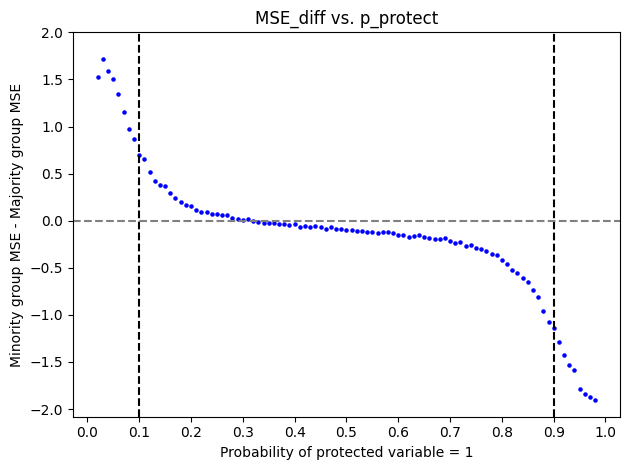

In [56]:
plot_MSEdiff_protect(p_protect, MSE_diff, "locallinearTau_causalForest_MSEdiffOnProb")

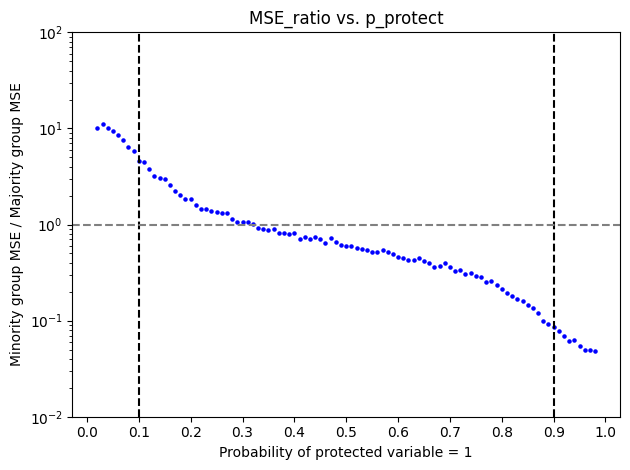

In [57]:
plot_MSEratio_protect(p_protect, MSE_minority, MSE_majority, "locallinearTau_causalForest_MSEratioOnProb")

In [13]:
mu_list = []
MSE_minority_train_list, MSE_majority_train_list, MSE_diff_train_list = [], [], []
MSE_minority_test_list, MSE_majority_test_list, MSE_diff_test_list = [], [], []
start_time = time.time()
for i in range(1, 81):
    # mu in (0,80]
    mu_list.append(i/4)
    MSE_minority_train, MSE_majority_train, MSE_diff_train, MSE_minority_test, MSE_majority_test, MSE_diff_test = run_causalForest_simulation(weight=i/4)
    MSE_minority_train_list.append(np.mean(MSE_minority_train))
    MSE_majority_train_list.append(np.mean(MSE_majority_train))
    MSE_diff_train_list.append(np.mean(MSE_diff_train))
    MSE_minority_test_list.append(np.mean(MSE_minority_test))
    MSE_majority_test_list.append(np.mean(MSE_majority_test))
    MSE_diff_test_list.append(np.mean(MSE_diff_test))
print("--- %s seconds ---" % (time.time() - start_time))

--- 2003.238049030304 seconds ---


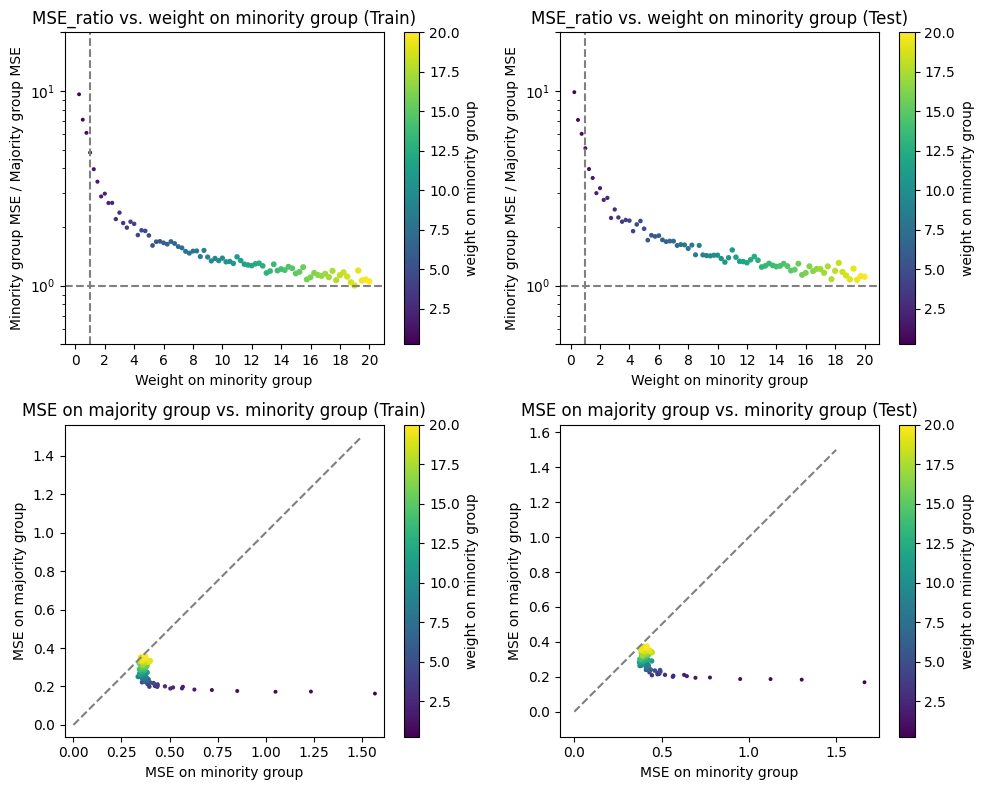

In [14]:
plot_MSE(mu_list, MSE_minority_train_list, MSE_majority_train_list, MSE_diff_train_list, 
         MSE_minority_test_list, MSE_majority_test_list, MSE_diff_test_list, 
         'locallinearTau_causalForest_MSEViz.png', custom_yticks = [5e-1, 1e0, 1e1, 2e1])
# custom_xticks=[i*8 for i in range(11)], custom_yticks=[i/2 for i in range(-1, 5, 1)], min_MSE=0, max_MSE=3)

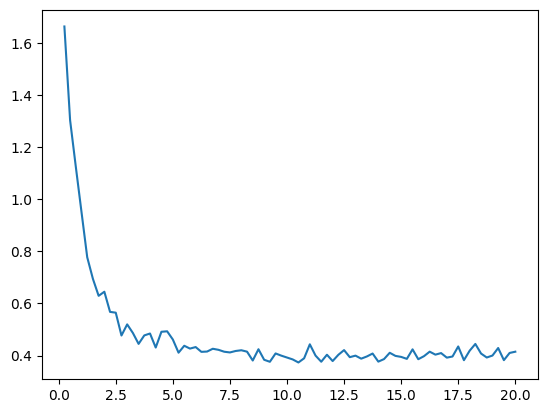

In [15]:
plt.plot(mu_list, MSE_minority_test_list)

In [16]:
MSE_minority_test_list

[1.6625892560945035,
 1.3029042473226153,
 1.1243437475149687,
 0.9502334279917706,
 0.7770560264066417,
 0.693964470808821,
 0.6290771136407646,
 0.6447960637984764,
 0.5674724350566973,
 0.5644333306778,
 0.4768539985108264,
 0.5194946640470068,
 0.4864874265462414,
 0.44469954684070906,
 0.4771803146837905,
 0.4844965066153513,
 0.4306875942054753,
 0.49115247447636284,
 0.49296725258018786,
 0.4614831038864777,
 0.41093495449730894,
 0.4374584376759863,
 0.4266458653234196,
 0.4324755583807481,
 0.4141345560686869,
 0.41527836081698305,
 0.4259692974477312,
 0.42189457475845027,
 0.4146183970608174,
 0.4118410279118387,
 0.41743492585581654,
 0.42023436832672145,
 0.4148412202087964,
 0.38087368485529766,
 0.42414114380679413,
 0.3836987634460777,
 0.376016366465503,
 0.4079797435751442,
 0.3995758633784098,
 0.39233387913810414,
 0.3850556042666682,
 0.3733419560963895,
 0.38936191041155577,
 0.44305415999789455,
 0.39977227811089494,
 0.37622792326660837,
 0.40302085451774944,
 0

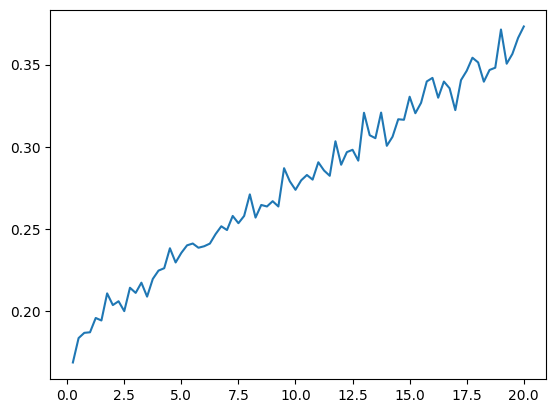

In [17]:
plt.plot(mu_list,MSE_majority_test_list)

In [18]:
MSE_majority_test_list

[0.1686812515334994,
 0.18353979210395824,
 0.18672807190147148,
 0.1870655064378898,
 0.19577297798815566,
 0.19424579977950773,
 0.2107470600968194,
 0.20363246962222356,
 0.2059631223154156,
 0.19993697900383853,
 0.21417892550084688,
 0.21104304777238778,
 0.21726985590839148,
 0.2087782681702279,
 0.21954400025229126,
 0.22462405536211413,
 0.22607650687041633,
 0.23822386054413935,
 0.22957462300839512,
 0.23541943523452122,
 0.23999769329719764,
 0.2411095394262976,
 0.23853597216477473,
 0.23944596748798294,
 0.24106774727206204,
 0.2468384677769081,
 0.2516031810538121,
 0.2493113109412169,
 0.2578990275405744,
 0.253480334383394,
 0.25789681600267267,
 0.2710222088275678,
 0.25690504331623826,
 0.26458617567035714,
 0.26366273410915414,
 0.2668780450277397,
 0.26365227911255895,
 0.28696889835694017,
 0.27901108157282406,
 0.2738063802112992,
 0.27958822677106854,
 0.2828308919337245,
 0.2800137278573995,
 0.29057871452681633,
 0.28556543762927045,
 0.28233764776599746,
 0.30

In [22]:
model = causalForest_estimator(X_train, W_train, Y_train)
model.feature_importances()

array([0.00449419, 0.01153188, 0.00097128, 0.78571841, 0.18935124,
       0.00793301])

In [23]:
model = causalForest_estimator(X_train, W_train, Y_train, weight_minority=20.0)
model.feature_importances()

array([0.02632699, 0.01315382, 0.00486755, 0.81855428, 0.07977356,
       0.05732379])

### Signal to Noise Ratio

In [90]:
# optimal points if trained on minority or majority group alone. 
def run_causalForest_simulation_minority(num_simulations=NUM_SIMULATIONS, weight=1.0, p_protect=0.1, noise_var=1.0, n=4000):
    MSE_minority_train, MSE_minority_test = [], []
    for i in range(num_simulations):
        X_train, W_train, Tau_train, Y_train = gen_imbalanced_data_locallinearTE(n=n, p_protect=p_protect, noise_var=noise_var)
        X_test, W_test, Tau_test, Y_test = gen_imbalanced_data_locallinearTE(n=1000, p_protect=p_protect, noise_var=noise_var)
        min_index = np.where(X_train[:,0] == 1)[0]
        model = causalForest_estimator(X_train[min_index], W_train[min_index], Y_train[min_index], weight_minority=weight)
        # eval on train data
        MSE_minority, MSE_majority, MSE_diff = eval_MSE_twoGroups(model.predict(X_train[min_index]), X_train[min_index], Tau_train[min_index])
        MSE_minority_train.append(MSE_minority)
        # eval on test data
        min_index = np.where(X_test[:,0] == 1)[0]
        MSE_minority, MSE_majority, MSE_diff = eval_MSE_twoGroups(model.predict(X_test[min_index]), X_test[min_index], Tau_test[min_index])
        MSE_minority_test.append(MSE_minority)
    return np.mean(MSE_minority_train), np.mean(MSE_minority_test)

In [27]:
optimal_MSE_min_train, optimal_MSE_min_test = run_causalForest_simulation_minority(noise_var=1.0)

In [91]:
# optimal points if trained on minority or majority group alone. 
def run_causalForest_simulation_majority(num_simulations=NUM_SIMULATIONS, weight=1.0, p_protect=0.1, noise_var=1.0, n=4000):
    MSE_majority_train, MSE_majority_test = [], []
    for i in range(num_simulations):
        X_train, W_train, Tau_train, Y_train = gen_imbalanced_data_locallinearTE(n=n, p_protect=p_protect, noise_var=noise_var)
        X_test, W_test, Tau_test, Y_test = gen_imbalanced_data_locallinearTE(n=1000, p_protect=p_protect, noise_var=noise_var)
        maj_index = np.where(X_train[:,0] == 0)[0]
        model = causalForest_estimator(X_train[maj_index], W_train[maj_index], Y_train[maj_index], weight_minority=weight)
        # eval on train data
        MSE_minority, MSE_majority, MSE_diff = eval_MSE_twoGroups(model.predict(X_train[maj_index]), X_train[maj_index], Tau_train[maj_index])
        MSE_majority_train.append(MSE_majority)
        # eval on test data
        maj_index = np.where(X_test[:,0] == 0)[0]
        MSE_minority, MSE_majority, MSE_diff = eval_MSE_twoGroups(model.predict(X_test[maj_index]), X_test[maj_index], Tau_test[maj_index])
        MSE_majority_test.append(MSE_majority)
    return np.mean(MSE_majority_train), np.mean(MSE_majority_test)

In [29]:
optimal_MSE_maj_train, optimal_MSE_maj_test = run_causalForest_simulation_majority(noise_var=1.0)

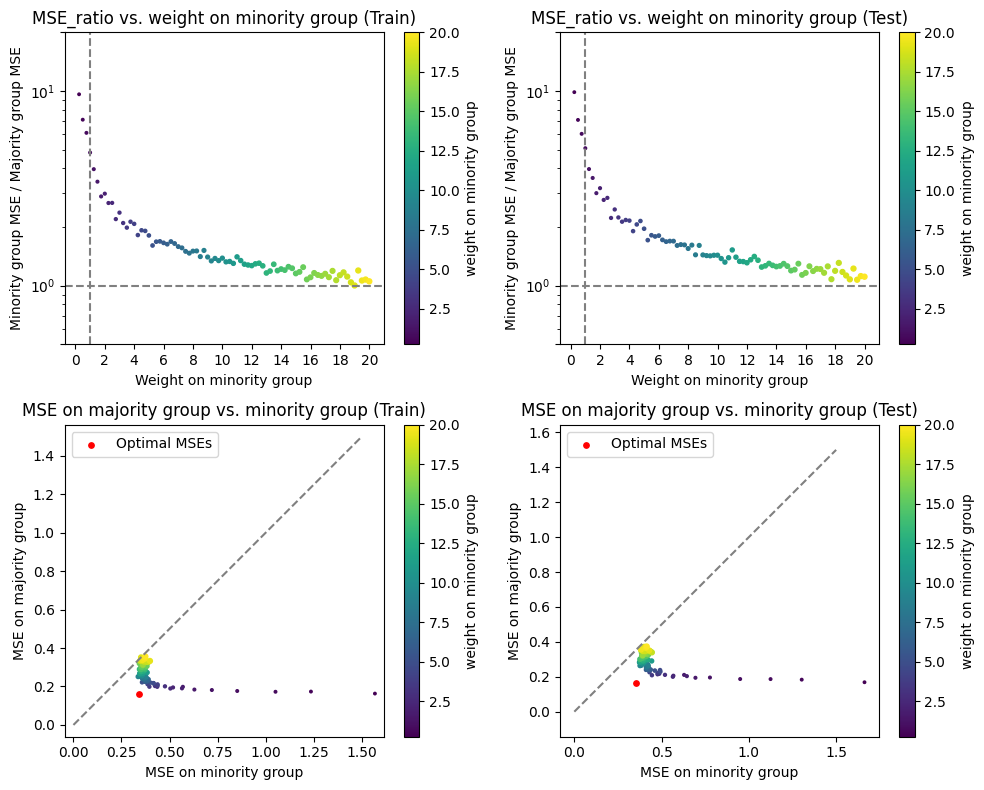

In [30]:
plot_MSE(mu_list, MSE_minority_train_list, MSE_majority_train_list, MSE_diff_train_list, 
         MSE_minority_test_list, MSE_majority_test_list, MSE_diff_test_list, 
         'locallinearTau_causalForest_MSEViz_5.0SNR.png',
         optimal_points = [optimal_MSE_min_train, optimal_MSE_maj_train, optimal_MSE_min_test, optimal_MSE_maj_test],
         custom_yticks = [5e-1, 1e0, 1e1, 2e1])

In [31]:
mu_list = []
MSE_minority_train_list, MSE_majority_train_list, MSE_diff_train_list = [], [], []
MSE_minority_test_list, MSE_majority_test_list, MSE_diff_test_list = [], [], []
for i in range(1, 81):
    # mu in (0,80]
    mu_list.append(i/4)
    MSE_minority_train, MSE_majority_train, MSE_diff_train, MSE_minority_test, MSE_majority_test, MSE_diff_test = run_causalForest_simulation(weight=i/4, noise_var=5.0)
    MSE_minority_train_list.append(np.mean(MSE_minority_train))
    MSE_majority_train_list.append(np.mean(MSE_majority_train))
    MSE_diff_train_list.append(np.mean(MSE_diff_train))
    MSE_minority_test_list.append(np.mean(MSE_minority_test))
    MSE_majority_test_list.append(np.mean(MSE_majority_test))
    MSE_diff_test_list.append(np.mean(MSE_diff_test))

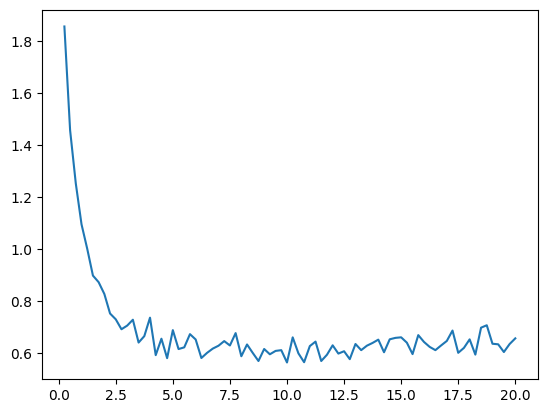

In [32]:
plt.plot(mu_list, MSE_minority_test_list)

In [33]:
MSE_minority_test_list

[1.8572813413668783,
 1.4578181593233634,
 1.2524022379440731,
 1.0956195105435351,
 1.0013324347545274,
 0.8980669993896917,
 0.8726823287601326,
 0.8272905721273858,
 0.7520709446937182,
 0.7297269886765446,
 0.691476602646144,
 0.7054550422052567,
 0.7281310058345314,
 0.6402261665162992,
 0.6649117339831118,
 0.7360616459136955,
 0.5917444663624862,
 0.6550050467607685,
 0.5801238630027273,
 0.6880826314838175,
 0.6151903392759059,
 0.6218014736085173,
 0.6725743893181435,
 0.6520763540362812,
 0.5807209072617581,
 0.6006069246278565,
 0.6169513552923087,
 0.6280369430478414,
 0.6458553151606731,
 0.6289292007671936,
 0.6766347981399166,
 0.587502968532436,
 0.6328402521395595,
 0.6003346703851331,
 0.5691686559994995,
 0.6154131299779728,
 0.5950520094533092,
 0.6080691204360462,
 0.6109016704243833,
 0.5635203534372359,
 0.6602408402452522,
 0.5987719686668767,
 0.5645198805160605,
 0.6266526411046656,
 0.643867644921939,
 0.5691675411456631,
 0.5931959127261898,
 0.6295978627493

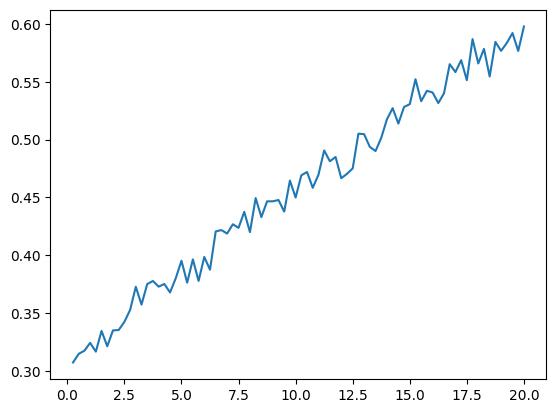

In [34]:
plt.plot(mu_list, MSE_majority_test_list)

In [35]:
MSE_majority_test_list

[0.3071875488848589,
 0.3146450642562714,
 0.3173944712472911,
 0.3241552828009209,
 0.3165831611574133,
 0.33446474728721237,
 0.32122784429675066,
 0.33493716548899116,
 0.3352670160465617,
 0.34231405080127714,
 0.35257395913937,
 0.3726514833180669,
 0.3572371459759172,
 0.3750090538623907,
 0.37767237856257935,
 0.3727824881020009,
 0.3750881718027656,
 0.3677697729746513,
 0.3800829827224248,
 0.39517449190316933,
 0.3762247320196155,
 0.3963722280713559,
 0.37773224768511654,
 0.3984689512519459,
 0.3874402307186142,
 0.42054353175327064,
 0.4217125395360612,
 0.41870510932748223,
 0.4267509637513819,
 0.4236375032887403,
 0.4375064962800755,
 0.4199400500557463,
 0.4494106552214401,
 0.4329292228764384,
 0.44656404952152107,
 0.44660878928472675,
 0.447716374766442,
 0.4377046239607298,
 0.4645296946724138,
 0.44988852842522264,
 0.4691101893800252,
 0.47196145644710824,
 0.4582850442704162,
 0.4695491837702875,
 0.49059189809955284,
 0.4812616256672345,
 0.4849314503138739,
 0

In [36]:
optimal_MSE_min_train, optimal_MSE_min_test = run_causalForest_simulation_minority(noise_var=5.0)

In [37]:
optimal_MSE_maj_train, optimal_MSE_maj_test = run_causalForest_simulation_majority(noise_var=5.0)

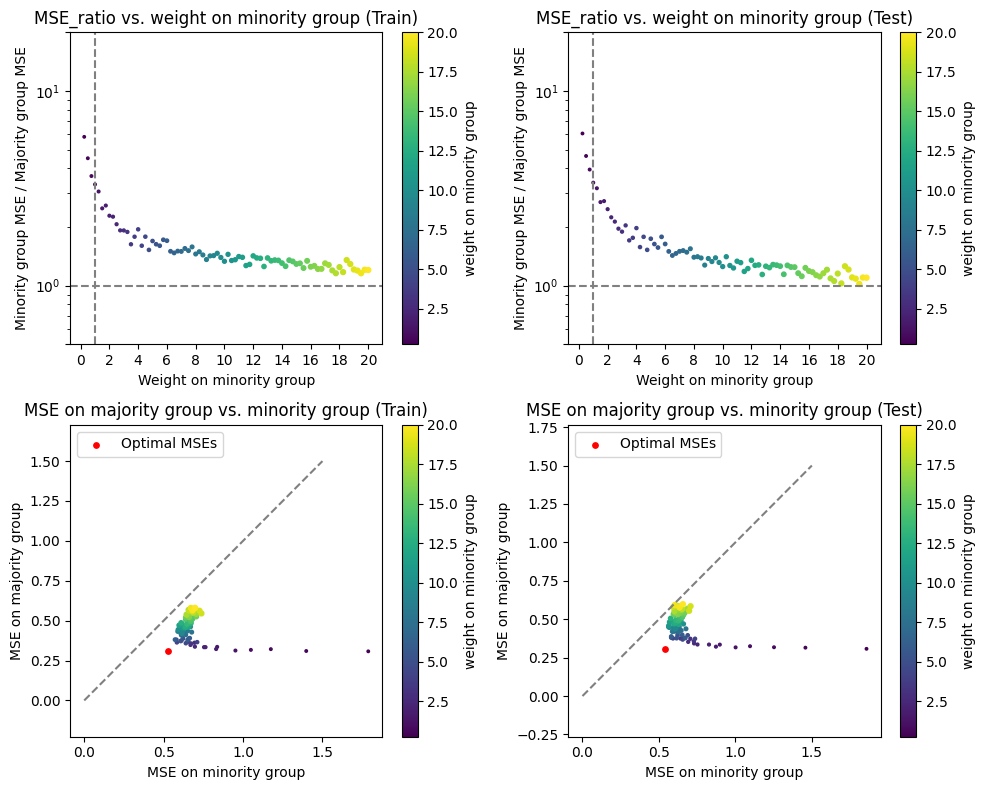

In [38]:
plot_MSE(mu_list, MSE_minority_train_list, MSE_majority_train_list, MSE_diff_train_list, 
         MSE_minority_test_list, MSE_majority_test_list, MSE_diff_test_list, 
         'locallinearTau_causalForest_MSEViz_1.0SNR.png',
         optimal_points = [optimal_MSE_min_train, optimal_MSE_maj_train, optimal_MSE_min_test, optimal_MSE_maj_test],
         custom_yticks = [5e-1, 1e0, 1e1, 2e1])

In [73]:
mu_list = []
MSE_minority_train_list, MSE_majority_train_list, MSE_diff_train_list = [], [], []
MSE_minority_test_list, MSE_majority_test_list, MSE_diff_test_list = [], [], []
for i in range(1, 81):
    # mu in (0,80]
    mu_list.append(i/4)
    MSE_minority_train, MSE_majority_train, MSE_diff_train, MSE_minority_test, MSE_majority_test, MSE_diff_test = run_causalForest_simulation(weight=i/4, noise_var=25.0)
    MSE_minority_train_list.append(np.mean(MSE_minority_train))
    MSE_majority_train_list.append(np.mean(MSE_majority_train))
    MSE_diff_train_list.append(np.mean(MSE_diff_train))
    MSE_minority_test_list.append(np.mean(MSE_minority_test))
    MSE_majority_test_list.append(np.mean(MSE_majority_test))
    MSE_diff_test_list.append(np.mean(MSE_diff_test))

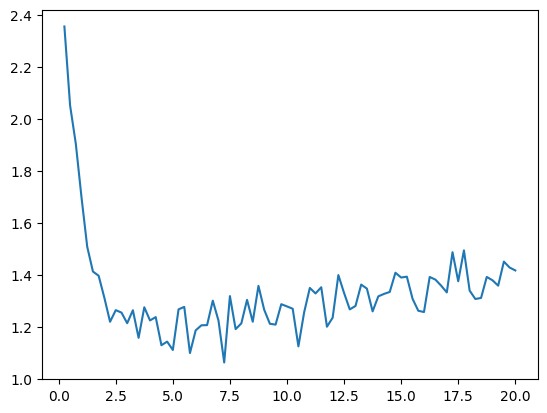

In [74]:
plt.plot(mu_list, MSE_minority_test_list)

In [75]:
MSE_minority_test_list

[2.354767727423942,
 2.0510015533667083,
 1.904000005925015,
 1.697628967774576,
 1.5080013966295411,
 1.4127589526278876,
 1.3965567589211632,
 1.3122108121425229,
 1.2196465850700107,
 1.2643246478365229,
 1.25491531316914,
 1.214093566377951,
 1.2639451526727705,
 1.157854751048027,
 1.2754106504811644,
 1.2247511086328722,
 1.2376391551257497,
 1.129414402544205,
 1.1433414803173942,
 1.1112116990986478,
 1.267322617003486,
 1.2769318974049313,
 1.0993599441863033,
 1.1865653204173052,
 1.2060238208265255,
 1.20682659648164,
 1.3008252259751654,
 1.2237970654713213,
 1.0631600565367358,
 1.318322513635407,
 1.1914441859972116,
 1.213474886580795,
 1.303859476742328,
 1.2198012768666957,
 1.3577247492665863,
 1.2662370883801866,
 1.211943054054346,
 1.2087235197386588,
 1.2871999140432857,
 1.2787160147847245,
 1.269709724900818,
 1.1251786239617378,
 1.2553602155221608,
 1.3497244691946892,
 1.328543419594491,
 1.3523731465207858,
 1.2006375408301324,
 1.2352883835062896,
 1.399161

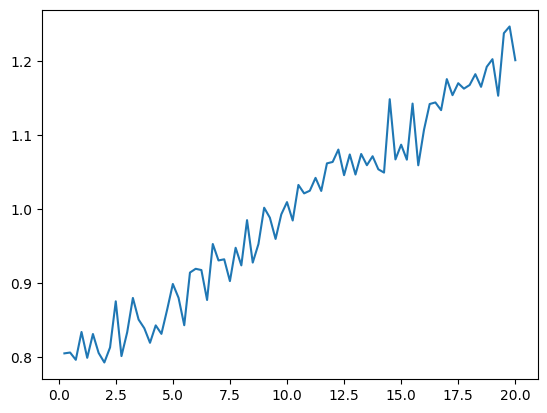

In [76]:
plt.plot(mu_list, MSE_majority_test_list)

In [77]:
MSE_majority_test_list

[0.8054241404950053,
 0.806573002320701,
 0.7967147744089138,
 0.8343544409374556,
 0.7994047326580003,
 0.8316086302546889,
 0.8059914601408203,
 0.7931193276532846,
 0.8134561020719865,
 0.8757936668355408,
 0.8017331970363467,
 0.8339105000184559,
 0.8803644402188148,
 0.8511440104926743,
 0.8394065931984096,
 0.8197370509408922,
 0.8432638559134328,
 0.8318024254338721,
 0.8644607774614934,
 0.8992466766024991,
 0.8805500615798627,
 0.8434857768752483,
 0.9146581574019487,
 0.9197733128297877,
 0.9180713780931251,
 0.8776129088706034,
 0.9532858952492858,
 0.931049369230716,
 0.932598313835848,
 0.90312001199203,
 0.9481993536389539,
 0.9243721358783666,
 0.9855373034175361,
 0.9281537783279822,
 0.9532473957260649,
 1.002323373383731,
 0.988820930301544,
 0.96012126482795,
 0.9933194611988578,
 1.0099076977210348,
 0.9850444380674752,
 1.0331330392944786,
 1.0217155811197391,
 1.0253137093755056,
 1.0426845088490464,
 1.0250065196990044,
 1.0622854348447175,
 1.0642017811828484,
 

In [78]:
optimal_MSE_min_train, optimal_MSE_min_test = run_causalForest_simulation_minority(noise_var=25.0)

In [79]:
optimal_MSE_maj_train, optimal_MSE_maj_test = run_causalForest_simulation_majority(noise_var=25.0)

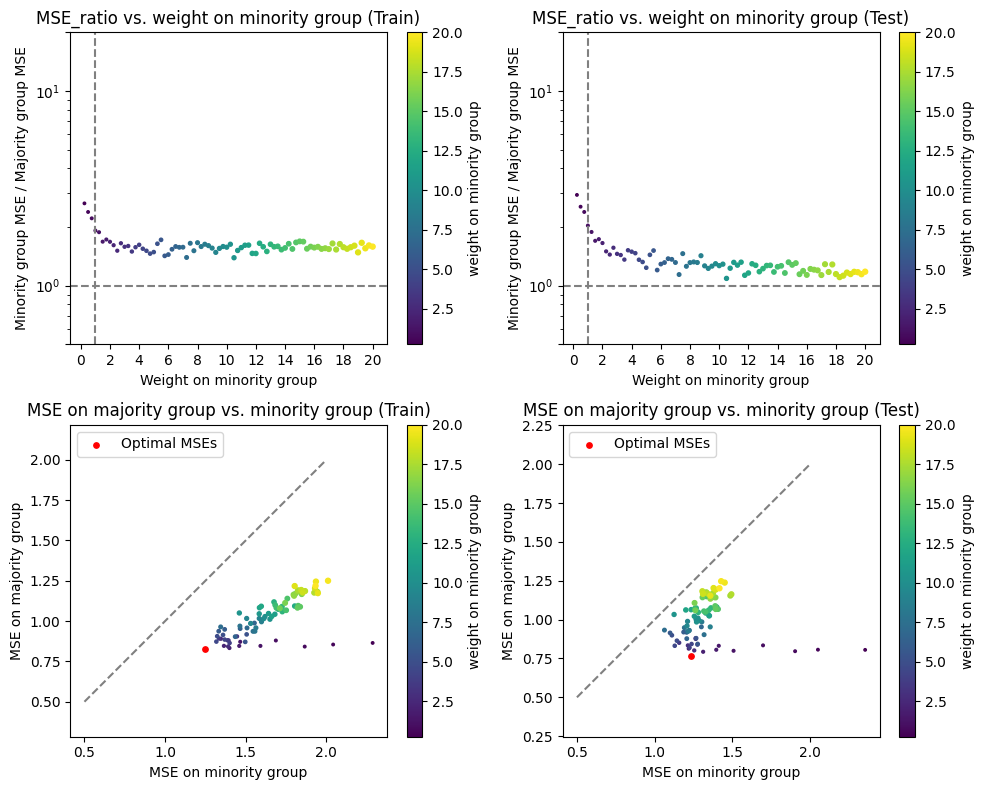

In [80]:
plot_MSE(mu_list, MSE_minority_train_list, MSE_majority_train_list, MSE_diff_train_list, 
         MSE_minority_test_list, MSE_majority_test_list, MSE_diff_test_list, 
         'locallinearTau_causalForest_MSEViz_0.2SNR.png', min_MSE = 0.5, max_MSE = 2.0,
         optimal_points = [optimal_MSE_min_train, optimal_MSE_maj_train, optimal_MSE_min_test, optimal_MSE_maj_test],
         custom_yticks = [5e-1, 1e0, 1e1, 2e1])

In [97]:
mu_list = []
MSE_minority_train_list, MSE_majority_train_list, MSE_diff_train_list = [], [], []
MSE_minority_test_list, MSE_majority_test_list, MSE_diff_test_list = [], [], []
for i in range(1, 81):
    # mu in (0,80]
    mu_list.append(i/4)
    MSE_minority_train, MSE_majority_train, MSE_diff_train, MSE_minority_test, MSE_majority_test, MSE_diff_test = run_causalForest_simulation(weight=i/4, noise_var=25.0, n=1000)
    MSE_minority_train_list.append(np.mean(MSE_minority_train))
    MSE_majority_train_list.append(np.mean(MSE_majority_train))
    MSE_diff_train_list.append(np.mean(MSE_diff_train))
    MSE_minority_test_list.append(np.mean(MSE_minority_test))
    MSE_majority_test_list.append(np.mean(MSE_majority_test))
    MSE_diff_test_list.append(np.mean(MSE_diff_test))

In [98]:
optimal_MSE_min_train, optimal_MSE_min_test = run_causalForest_simulation_minority(noise_var=25.0, n=1000)

In [99]:
optimal_MSE_maj_train, optimal_MSE_maj_test = run_causalForest_simulation_majority(noise_var=25.0, n=1000)

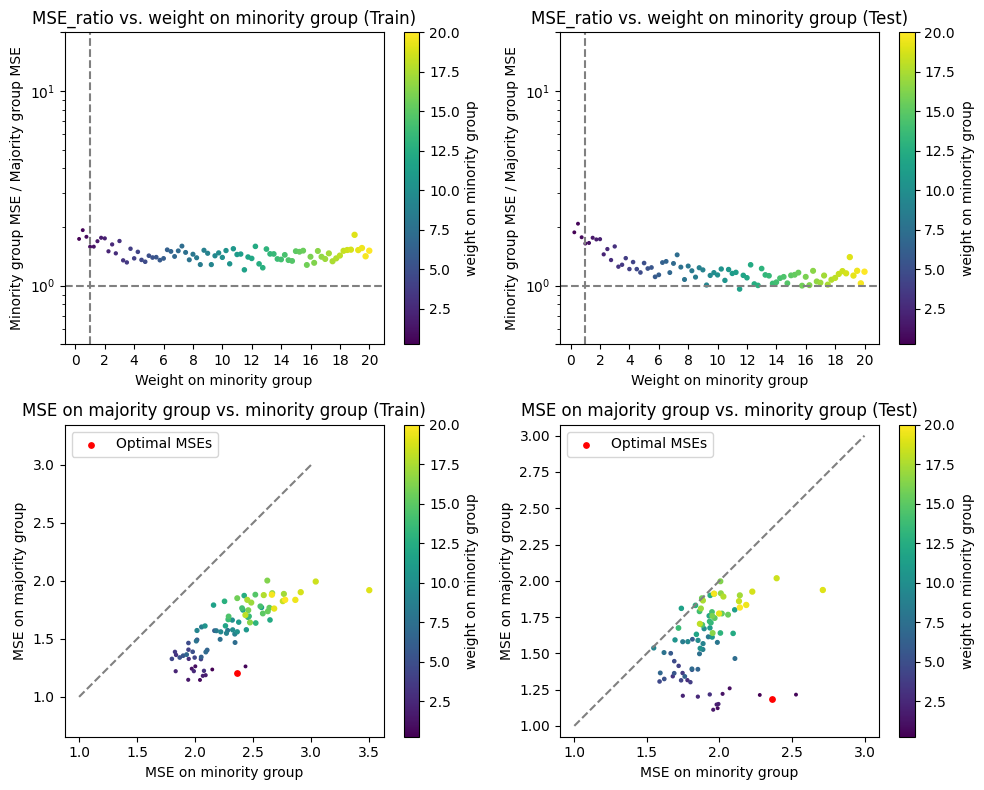

In [100]:
plot_MSE(mu_list, MSE_minority_train_list, MSE_majority_train_list, MSE_diff_train_list, 
         MSE_minority_test_list, MSE_majority_test_list, MSE_diff_test_list, 
         'locallinearTau_causalForest_MSEViz_0.2SNR_1000train.png', min_MSE = 1.0, max_MSE = 3.0,
         optimal_points = [optimal_MSE_min_train, optimal_MSE_maj_train, optimal_MSE_min_test, optimal_MSE_maj_test],
         custom_yticks = [5e-1, 1e0, 1e1, 2e1])

# WGAN Synthetic Data Augmentation

In [47]:
import pandas as pd

In [48]:
X_train, W_train, Tau_train, Y_train = gen_imbalanced_data_locallinearTE()
X_test, W_test, Tau_test, Y_test = gen_imbalanced_data_locallinearTE(n=1000)
# sanity check:
# shapes, should expect 4000x6, 4000, 4000, and 4000
print(X_train.shape, W_train.shape, Tau_train.shape, Y_train.shape)
# should expect numbers close to 0.1, 0.5, and 0
print(np.sum(X_train[:,0]) / len(X_train), np.sum(W_train) / len(W_train), np.sum(X_train[:,-1]) / len(X_train))
print("Some examples of Y:", Y_train[:5])

(4000, 6) (4000,) (4000,) (4000,)
0.1045 0.49075 -0.0041696244647369
Some examples of Y: [ 2.19071173 -0.8673918   2.03666224  3.25976984  6.53450559]


In [49]:
train_concat = np.column_stack((np.array(W_train), np.array(X_train), np.array(Y_train)))
df_train = pd.DataFrame(train_concat, columns=['t', 'cat1', 'cat2', 'cat3', 'cont1', 'cont2', 'cont3', 'y'])

In [50]:
# df_train.to_csv('df_train.csv', index=False)

In [51]:
df_generated = pd.read_csv("df_generated_noBalance/df_generated_noBalance.csv")

In [52]:
df_generated.head()

,source,y,cont1,cont2,cont3,cat1,cat2,cat3,t,y_cf
0,fake,1.011340,-1.409484,0.674902,0.372420,0.0,0.0,0.0,1.0,0.864927
1,fake,1.662762,-0.545857,0.789179,0.745671,0.0,0.0,1.0,0.0,2.619851
2,fake,1.479594,1.089281,1.830297,-0.249418,0.0,0.0,0.0,0.0,4.825170
3,fake,1.573747,-0.216748,-0.401866,1.190368,0.0,1.0,0.0,1.0,2.023239
4,fake,1.540797,1.887917,-1.394110,-1.179315,0.0,0.0,1.0,1.0,0.499681


In [53]:
tau_generated = df_generated.cat1 + df_generated.cat2 + df_generated.cont1 + (1-df_generated.cat1) * df_generated.cont2

In [54]:
pred_generated = (df_generated.y - df_generated.y_cf)*df_generated.t + (df_generated.y_cf - df_generated.y)*(1-df_generated.t)

In [55]:
mean_squared_error(tau_generated, pred_generated) # that's very interesting, it's much worse than our CATE.

1.7528136781239854

In [56]:
np.corrcoef(tau_generated, pred_generated)[0, 1]

0.594345104103227

## After balancing protected variable

In [57]:
df_generated = pd.read_csv("df_generated_yesBalance/df_generated_yesBalance.csv")

In [59]:
tau_generated = df_generated.cat1 + df_generated.cat2 + df_generated.cont1 + (1-df_generated.cat1) * df_generated.cont2
pred_generated = (df_generated.y - df_generated.y_cf)*df_generated.t + (df_generated.y_cf - df_generated.y)*(1-df_generated.t)

In [60]:
mean_squared_error(tau_generated, pred_generated)

3.589298180036196

In [61]:
np.corrcoef(tau_generated, pred_generated)[0, 1]

0.5441450292067381

## Synthetic Data Augmentation

In [139]:
def plot_MSE_aug(ratio_list, train_min, train_maj, train_diff, test_min, test_maj, test_diff, 
             name=None, custom_xticks=None, custom_yticks=None, min_MSE=0, max_MSE=1.0, optimal_points=None):
    
    plt.figure(figsize=(10,8))
    
    # plot ratio of MSE with respect to weight on minority (Train)
    plt.subplot(2, 2, 1)
    scatter_1 = plt.scatter(ratio_list, np.array(train_min) / np.array(train_maj), c=ratio_list, cmap='viridis', s=np.array(ratio_list)*8+3)
    plt.yscale('log')
    plt.colorbar(scatter_1, label='minority group size / majority group size')
    plt.axvline(x=1, color="grey", linestyle='--')
    plt.axhline(y=1.0, color="grey", linestyle='--')
    plt.xlabel('minority group size / majority group size')
    plt.ylabel('Minority group MSE / Majority group MSE')
    if custom_xticks is None:
        custom_xticks = [i/2 for i in range(11)] # Custom x-axis tick locations
    if custom_yticks is None:
        custom_yticks = [1e-1, 1e0, 1e1, 1e2] # Custom y-axis tick locations
    plt.xticks(custom_xticks)
    plt.yticks(custom_yticks)
    plt.title('MSE_ratio vs. minority group size (Train)')
    
    #  plot ratio of MSE with respect to weight on minority (Test)
    plt.subplot(2, 2, 2)
    scatter_2 = plt.scatter(ratio_list, np.array(test_min) / np.array(test_maj), c=ratio_list, cmap='viridis', s=np.array(ratio_list)*8+3)
    plt.yscale('log')
    plt.colorbar(scatter_2, label='minority group size / majority group size')
    plt.axvline(x=1, color="grey", linestyle='--')
    plt.axhline(y=1.0, color="grey", linestyle='--')
    plt.xlabel('minority group size / majority group size')
    plt.ylabel('Minority group MSE / Majority group MSE')
    if custom_xticks is None:
        custom_xticks = [i/2 for i in range(11)] # Custom x-axis tick locations
    if custom_yticks is None:
        custom_yticks = [1e-1, 1e0, 1e1, 1e2] # Custom y-axis tick locations
    plt.xticks(custom_xticks)
    plt.yticks(custom_yticks)
    plt.title('MSE_ratio vs. minority group size (Test)')
    
    # plot MSE on majority vs. on minority (Train)
    plt.subplot(2, 2, 3)
    # smaller circles indicate smaller weight
    scatter_3 = plt.scatter(train_min, train_maj, c=ratio_list, cmap='viridis', s=np.array(ratio_list)*8+3)
    plt.colorbar(scatter_3, label='minority group size / majority group size')
    if optimal_points is not None:
        plt.scatter(optimal_points[0], optimal_points[1], color='red', marker='o', s=15, label = "Optimal MSEs")
    plt.plot(np.linspace(min_MSE, max_MSE, 100), np.linspace(min_MSE, max_MSE, 100), linestyle='--', color='grey', label='45-Degree Line')
    plt.xlabel('MSE on minority group')
    plt.ylabel('MSE on majority group')
    plt.axis('equal')
    plt.title('MSE on majority group vs. minority group (Train)')
    
    # plot MSE on majority vs. on minority (Test)
    plt.subplot(2, 2, 4)
    # smaller circles indicate smaller weight
    scatter_4 = plt.scatter(test_min, test_maj, c=ratio_list, cmap='viridis', s=np.array(ratio_list)*8+3)
    plt.colorbar(scatter_4, label='minority group size / majority group size')
    if optimal_points is not None:
        plt.scatter(optimal_points[2], optimal_points[3], color='red', marker='o', s=15, label = "Optimal MSEs")
    plt.plot(np.linspace(min_MSE, max_MSE, 100), np.linspace(min_MSE, max_MSE, 100), linestyle='--', color='grey', label='45-Degree Line')
    plt.xlabel('MSE on minority group')
    plt.ylabel('MSE on majority group')
    plt.axis('equal')
    plt.title('MSE on majority group vs. minority group (Test)')
    
    plt.tight_layout()
    if name is not None:
        plt.savefig(name, dpi=200)
    plt.show()

In [116]:
# df_generated = pd.read_csv("df_generated_noBalance/df_generated_noBalance.csv")
df_generated = pd.read_csv("df_generated_yesBalance/df_generated_yesBalance.csv")

In [117]:
df_generated_minority = df_generated[df_generated["cat1"] == 1]

In [118]:
df_generated_minority.shape

(49755, 10)

Try finer detail increments and run multiple times to get an average, also label the points with the amount of synthetic data added if possible

In [119]:
ratio_list = []
MSE_minority_train_list, MSE_majority_train_list, MSE_diff_train_list = [], [], []
MSE_minority_test_list, MSE_majority_test_list, MSE_diff_test_list = [], [], []
num_min = np.sum(X_train[:,0] == 1)
num_maj = np.sum(X_train[:,0] == 0)
assert(num_min + num_maj == 4000)

start_time = time.time()
for i in range(41):
    # everytime add 80 more minority data point to training set
    ratio_list.append((num_min+i*80)/num_maj)

    MSE_minority_train_temp, MSE_majority_train_temp, MSE_diff_train_temp = [], [], []
    MSE_minority_test_temp, MSE_majority_test_temp, MSE_diff_test_temp = [], [], []
    for j in range(NUM_SIMULATIONS):
        if i != 0:
            df_sampled = df_generated_minority.sample(80*i)
            X = np.vstack((X_train,df_sampled[["cat1","cat2","cat3","cont1","cont2","cont3"]].values))
            W = np.hstack((W_train,df_sampled["t"].values))
            Y = np.hstack((Y_train,df_sampled["y"].values))
        else:
            X = X_train
            W = W_train
            Y = Y_train
        model = causalForest_estimator(X, W, Y)
        # eval on train data
        CATE_pred = model.predict(X_train)[:,0]
        MSE_minority, MSE_majority, MSE_diff = eval_MSE_twoGroups(CATE_pred, X_train, Tau_train)
        MSE_minority_train_temp.append(MSE_minority)
        MSE_majority_train_temp.append(MSE_majority)
        MSE_diff_train_temp.append(MSE_diff)
        # eval on test data
        CATE_pred = model.predict(X_test)[:,0]
        MSE_minority, MSE_majority, MSE_diff = eval_MSE_twoGroups(CATE_pred, X_test, Tau_test)
        MSE_minority_test_temp.append(MSE_minority)
        MSE_majority_test_temp.append(MSE_majority)
        MSE_diff_test_temp.append(MSE_diff)
    
    MSE_minority_train_list.append(np.mean(MSE_minority_train_temp))
    MSE_majority_train_list.append(np.mean(MSE_majority_train_temp))
    MSE_diff_train_list.append(np.mean(MSE_diff_train_temp))
    
    MSE_minority_test_list.append(np.mean(MSE_minority_test_temp))
    MSE_majority_test_list.append(np.mean(MSE_majority_test_temp))
    MSE_diff_test_list.append(np.mean(MSE_diff_test_temp))
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 2639.9393191337585 seconds ---


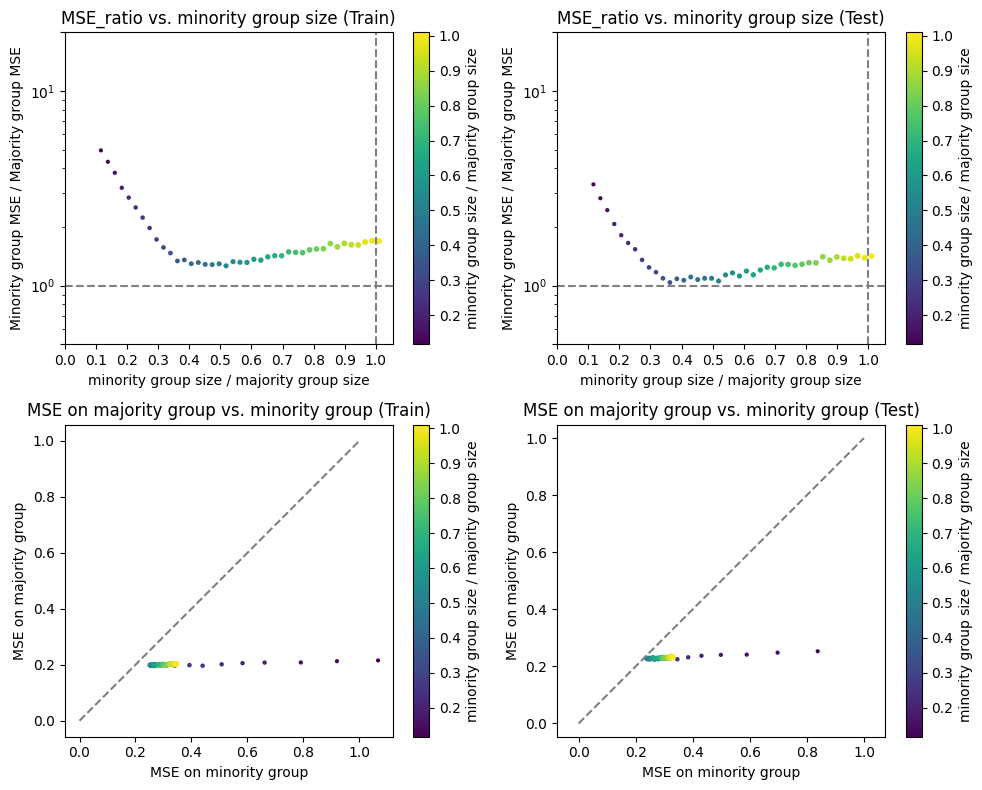

In [120]:
plot_MSE_aug(ratio_list, MSE_minority_train_list, MSE_majority_train_list, MSE_diff_train_list, 
         MSE_minority_test_list, MSE_majority_test_list, MSE_diff_test_list, 
         'locallinearTau_causalForest_WGANAug_MSEViz.png',
         custom_xticks=[i/10 for i in range(0, 11, 1)], custom_yticks = [5e-1, 1e0, 1e1, 2e1])

In [114]:
save_temp = [ratio_list, MSE_minority_train_list, MSE_majority_train_list, MSE_diff_train_list, MSE_minority_test_list, MSE_majority_test_list, MSE_diff_test_list]


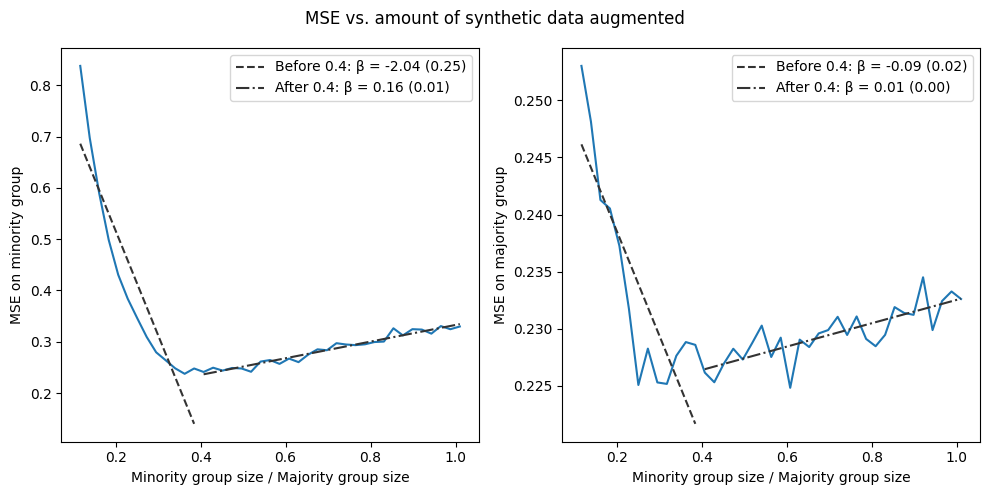

In [121]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(ratio_list, MSE_minority_test_list)

idx = 13
x_first_half, y_first_half = ratio_list[:idx], MSE_minority_test_list[:idx]
x_second_half, y_second_half = ratio_list[idx:], MSE_minority_test_list[idx:]

# Fitting lines to the first and second halves of the data
coefficients_first_half, cov_first_half = np.polyfit(x_first_half, y_first_half, 1, cov=True)
coefficients_second_half, cov_second_half = np.polyfit(x_second_half, y_second_half, 1, cov=True)

# Generating the line equations
line_first_half = np.poly1d(coefficients_first_half)
line_second_half = np.poly1d(coefficients_second_half)

# Extracting standard deviation from the covariance matrix
std_dev_first_half = np.sqrt(np.diag(cov_first_half))[0]
std_dev_second_half = np.sqrt(np.diag(cov_second_half))[0]

# Plotting the lines of best fit for the first and second halves
color='#333333'
plt.plot(x_first_half, line_first_half(x_first_half), label=f'Before 0.4: β = {coefficients_first_half[0]:.2f} ({std_dev_first_half:.2f})', linestyle = '--', color=color)
plt.plot(x_second_half, line_second_half(x_second_half), label=f'After 0.4: β = {coefficients_second_half[0]:.2f} ({std_dev_second_half:.2f})', linestyle = '-.', color=color)
# plt.axvline(x=mu_list[idx], color='black', linestyle='-.')

# Adding text above each line with the beta coefficient
# plt.text((1+1+idx / 4)/2, line_first_half((1+1+idx / 4)/2)-10, f'slope: {coefficients_first_half[0]:.2f} ({std_dev_first_half:.2f})', fontsize=10, ha='center', color=color)
# plt.text((12+1+idx / 4)/2, line_second_half((12+1+idx / 4)/2)-10, f'slope: {coefficients_second_half[0]:.2f} ({std_dev_second_half:.2f})', fontsize=10, ha='center', color=color)

# plt.xticks([1.5,3.0,4.5,6,7.5,9,10.5,12])
plt.legend()
plt.xlabel('Minority group size / Majority group size')
plt.ylabel('MSE on minority group')

# second plot for majority
plt.subplot(1, 2, 2)
plt.plot(ratio_list, MSE_majority_test_list)

idx = 13
x_first_half, y_first_half = ratio_list[:idx], MSE_majority_test_list[:idx]
x_second_half, y_second_half = ratio_list[idx:], MSE_majority_test_list[idx:]

# Fitting lines to the first and second halves of the data
coefficients_first_half, cov_first_half = np.polyfit(x_first_half, y_first_half, 1, cov=True)
coefficients_second_half, cov_second_half = np.polyfit(x_second_half, y_second_half, 1, cov=True)

# Generating the line equations
line_first_half = np.poly1d(coefficients_first_half)
line_second_half = np.poly1d(coefficients_second_half)

# Extracting standard deviation from the covariance matrix
std_dev_first_half = np.sqrt(np.diag(cov_first_half))[0]
std_dev_second_half = np.sqrt(np.diag(cov_second_half))[0]

# Plotting the lines of best fit for the first and second halves
color='#333333'
plt.plot(x_first_half, line_first_half(x_first_half), label=f'Before 0.4: β = {coefficients_first_half[0]:.2f} ({std_dev_first_half:.2f})', linestyle = '--', color=color)
plt.plot(x_second_half, line_second_half(x_second_half), label=f'After 0.4: β = {coefficients_second_half[0]:.2f} ({std_dev_second_half:.2f})', linestyle = '-.', color=color)
# plt.axvline(x=mu_list[idx], color='black', linestyle='-.')

# plt.xticks([1.5,3.0,4.5,6,7.5,9,10.5,12])
plt.legend()
plt.xlabel('Minority group size / Majority group size')
plt.ylabel('MSE on majority group')

fig.suptitle('MSE vs. amount of synthetic data augmented') #  fontsize=16, y=1.05
plt.tight_layout()
plt.savefig("MSE_augratio_best_fit", dpi=200)
plt.show()


## Synthetic Data Augmentation for Small SNR

In [122]:
X_train, W_train, Tau_train, Y_train = gen_imbalanced_data_locallinearTE(noise_var=25.0)
X_test, W_test, Tau_test, Y_test = gen_imbalanced_data_locallinearTE(n=1000, noise_var=25.0)
# sanity check:
# shapes, should expect 4000x6, 4000, 4000, and 4000
print(X_train.shape, W_train.shape, Tau_train.shape, Y_train.shape)
# should expect numbers close to 0.1, 0.5, and 0
print(np.sum(X_train[:,0]) / len(X_train), np.sum(W_train) / len(W_train), np.sum(X_train[:,-1]) / len(X_train))
print("Some examples of Y:", Y_train[:5])

(4000, 6) (4000,) (4000,) (4000,)
0.09875 0.48975 -0.0015766354130433465
Some examples of Y: [ 1.30887253  4.07135978  1.31571122  3.47907392 -2.16790268]


In [124]:
train_concat = np.column_stack((np.array(W_train), np.array(X_train), np.array(Y_train)))
df_train = pd.DataFrame(train_concat, columns=['t', 'cat1', 'cat2', 'cat3', 'cont1', 'cont2', 'cont3', 'y'])

In [125]:
df_train.to_csv('df_0.2SNR_train.csv', index=False)

In [126]:
df_generated = pd.read_csv("df_0.2SNR_generated.csv")

In [127]:
tau_generated = df_generated.cat1 + df_generated.cat2 + df_generated.cont1 + (1-df_generated.cat1) * df_generated.cont2
pred_generated = (df_generated.y - df_generated.y_cf)*df_generated.t + (df_generated.y_cf - df_generated.y)*(1-df_generated.t)

In [128]:
mean_squared_error(tau_generated, pred_generated)

23.728064354928584

In [129]:
np.corrcoef(tau_generated, pred_generated)[0, 1]

0.29946320174829333

In [130]:
df_generated = pd.read_csv("df_0.2SNR_generated.csv")

In [131]:
df_generated_minority = df_generated[df_generated["cat1"] == 1]

In [132]:
df_generated_minority.shape

(546422, 10)

In [133]:
ratio_list = []
MSE_minority_train_list, MSE_majority_train_list, MSE_diff_train_list = [], [], []
MSE_minority_test_list, MSE_majority_test_list, MSE_diff_test_list = [], [], []
num_min = np.sum(X_train[:,0] == 1)
num_maj = np.sum(X_train[:,0] == 0)
assert(num_min + num_maj == 4000)

start_time = time.time()
for i in range(41):
    # everytime add 80 more minority data point to training set
    ratio_list.append((num_min+i*80)/num_maj)

    MSE_minority_train_temp, MSE_majority_train_temp, MSE_diff_train_temp = [], [], []
    MSE_minority_test_temp, MSE_majority_test_temp, MSE_diff_test_temp = [], [], []
    for j in range(NUM_SIMULATIONS):
        if i != 0:
            df_sampled = df_generated_minority.sample(80*i)
            X = np.vstack((X_train,df_sampled[["cat1","cat2","cat3","cont1","cont2","cont3"]].values))
            W = np.hstack((W_train,df_sampled["t"].values))
            Y = np.hstack((Y_train,df_sampled["y"].values))
        else:
            X = X_train
            W = W_train
            Y = Y_train
        model = causalForest_estimator(X, W, Y)
        # eval on train data
        CATE_pred = model.predict(X_train)[:,0]
        MSE_minority, MSE_majority, MSE_diff = eval_MSE_twoGroups(CATE_pred, X_train, Tau_train)
        MSE_minority_train_temp.append(MSE_minority)
        MSE_majority_train_temp.append(MSE_majority)
        MSE_diff_train_temp.append(MSE_diff)
        # eval on test data
        CATE_pred = model.predict(X_test)[:,0]
        MSE_minority, MSE_majority, MSE_diff = eval_MSE_twoGroups(CATE_pred, X_test, Tau_test)
        MSE_minority_test_temp.append(MSE_minority)
        MSE_majority_test_temp.append(MSE_majority)
        MSE_diff_test_temp.append(MSE_diff)
    
    MSE_minority_train_list.append(np.mean(MSE_minority_train_temp))
    MSE_majority_train_list.append(np.mean(MSE_majority_train_temp))
    MSE_diff_train_list.append(np.mean(MSE_diff_train_temp))
    
    MSE_minority_test_list.append(np.mean(MSE_minority_test_temp))
    MSE_majority_test_list.append(np.mean(MSE_majority_test_temp))
    MSE_diff_test_list.append(np.mean(MSE_diff_test_temp))
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 1977.3601531982422 seconds ---


In [137]:
optimal_MSE_min_train, optimal_MSE_min_test = run_causalForest_simulation_minority(noise_var=25.0)

In [138]:
optimal_MSE_maj_train, optimal_MSE_maj_test = run_causalForest_simulation_majority(noise_var=25.0)

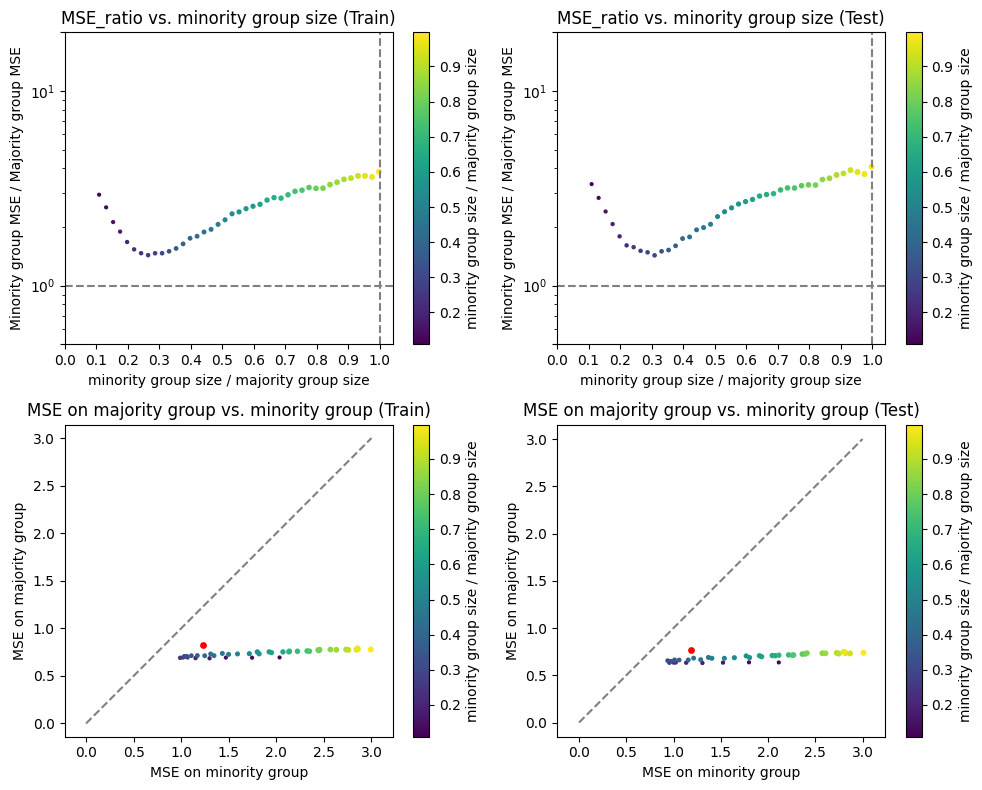

In [140]:
plot_MSE_aug(ratio_list, MSE_minority_train_list, MSE_majority_train_list, MSE_diff_train_list, 
         MSE_minority_test_list, MSE_majority_test_list, MSE_diff_test_list, 
         'locallinearTau_0.2SNR_causalForest_WGANAug_MSEViz.png',
         custom_xticks=[i/10 for i in range(0, 11, 1)], custom_yticks = [5e-1, 1e0, 1e1, 2e1], max_MSE = 3.0,
         optimal_points = [optimal_MSE_min_train, optimal_MSE_maj_train, optimal_MSE_min_test, optimal_MSE_maj_test])

### End of Notebook

In [ ]:
print("--- %s seconds ---" % (time.time() - global_start_time))